# Import statements

In [ ]:
!pip install wfdb
!pip install spkit
!pip install neurokit2
!pip install tf_keras_vis
!pip install pydot
!pip install graphviz

In [1]:
#preprocess
import wfdb
import matplotlib.pyplot as plt
import spkit as sp
import neurokit2 as nk
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# Model
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import json
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.utils import plot_model
import pydot
import graphviz

#saliency maps
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.scorecam import Scorecam
import scipy.ndimage
from tf_keras_vis.utils.model_modifiers import GuidedBackpropagation
import scipy.ndimage

# Activation Maximization
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.regularizers import Norm, Regularizer
from tf_keras_vis.activation_maximization.input_modifiers import Jitter

/opt/conda/lib/python3.11/site-packages/neurokit2/signal/signal_findpeaks.py:3: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
/opt/conda/lib/python3.11/site-packages/tf_keras_vis/gradcam.py:6: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
/opt/conda/lib/python3.11/site-packages/tf_keras_vis/gradcam_plus_plus.py:6: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
/opt/conda/lib/python3.11/site-packages/tf_keras_vis/scorecam.py:6: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
/opt/conda/lib/python3.11/site-packages/tf_keras_vis/utils/regularizers.py:8: DeprecationWarning: `tf_keras_vis.utils.reg

# Preprocess

## Load data

Loads the whole dataset from physionet and extracts the signals, P and R peak annotations and the sampling frequency.

In [2]:
# get the data 
record_names = wfdb.get_record_list('but-pdb')
database = 'but-pdb'

#store data from different records
signals = []
p_anns = []
r_anns = []
samp_freq = []

for i, rec in enumerate(record_names):
    #load record
    record = wfdb.rdrecord(f"{int(rec):02}", pn_dir = database)
    if record.fs != 360:
        continue
    if i == 35:
        break
    

    #load signal and annotations
    sig = record.p_signal[:,0]
    p_ann = wfdb.rdann(f"{int(rec):02}", 'pwave', pn_dir=database)
    if len(p_ann.sample) < 10:
        continue
    r_ann = wfdb.rdann(f"{int(rec):02}", 'qrs', pn_dir = database)

    print(f"Record being collected is record number: {int(rec):02}")
    #store signals and annotations
    signals.append(sig)
    p_anns.append(p_ann)
    r_anns.append(r_ann)
    samp_freq.append(record.fs)

Record being collected is record number: 01
Record being collected is record number: 02
Record being collected is record number: 03
Record being collected is record number: 04
Record being collected is record number: 05
Record being collected is record number: 06
Record being collected is record number: 07
Record being collected is record number: 09
Record being collected is record number: 10
Record being collected is record number: 11
Record being collected is record number: 12
Record being collected is record number: 13
Record being collected is record number: 14
Record being collected is record number: 15
Record being collected is record number: 16
Record being collected is record number: 17
Record being collected is record number: 18
Record being collected is record number: 19
Record being collected is record number: 20
Record being collected is record number: 21
Record being collected is record number: 22
Record being collected is record number: 23
Record being collected is record

In [5]:
len(signals)

34

## plot signals

to understand the data better, we can plot a few and see what the data looks like

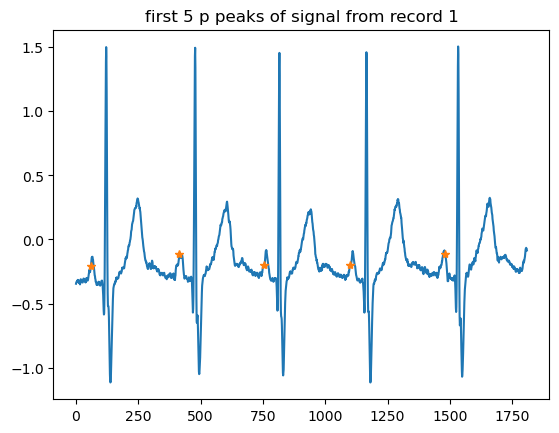

0 is complete


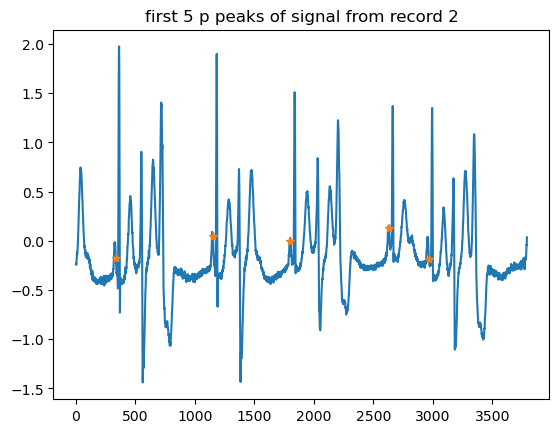

1 is complete


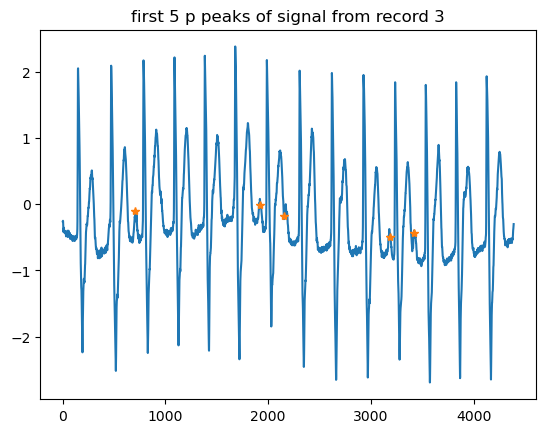

2 is complete


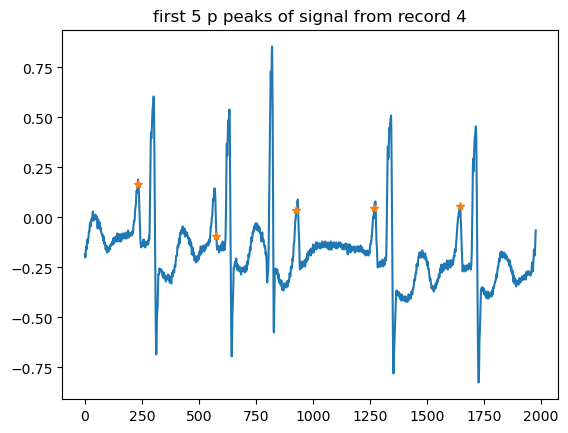

3 is complete


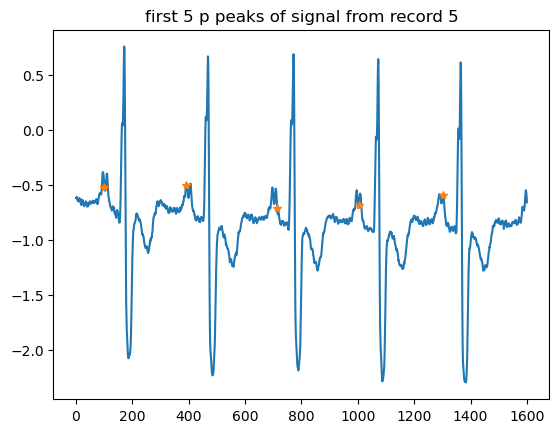

4 is complete


In [6]:
#plot signal and P peaks
for i in range(5):
    plt.title(f'first 5 p peaks of signal from record {i+1}')
    plt.plot(signals[i][:p_anns[i].sample[5]])
    plt.plot(p_anns[i].sample[:5],signals[i][p_anns[i].sample[:5]],'*')
    plt.show()
    print(f'{i} is complete')

## Clean the signals

after plotting the signals, you can see that there are a lot of small and large noises, this function will just slightly smooth it out a bit, which is better for when we are training the model

/opt/conda/lib/python3.11/site-packages/scipy/signal/_filter_design.py:2914: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


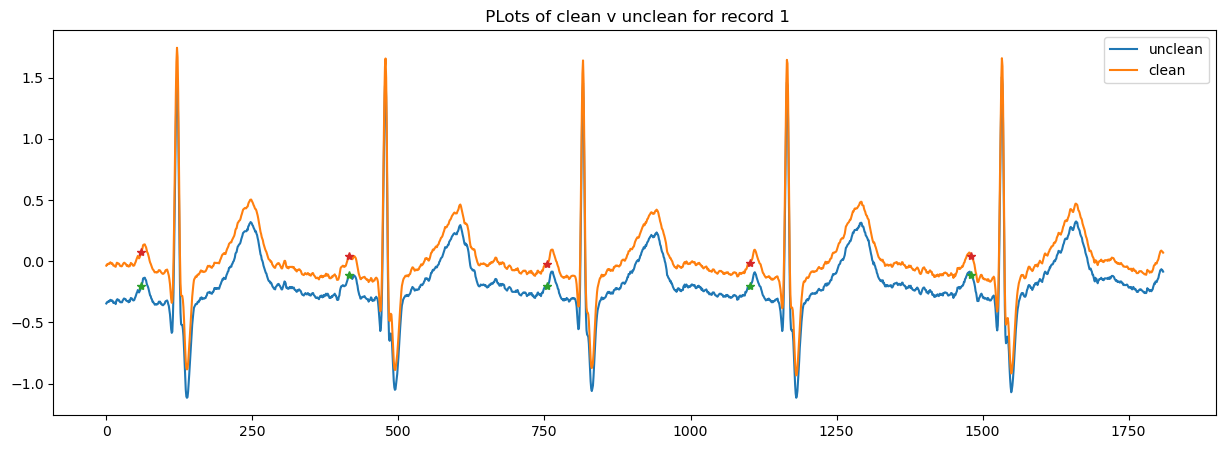

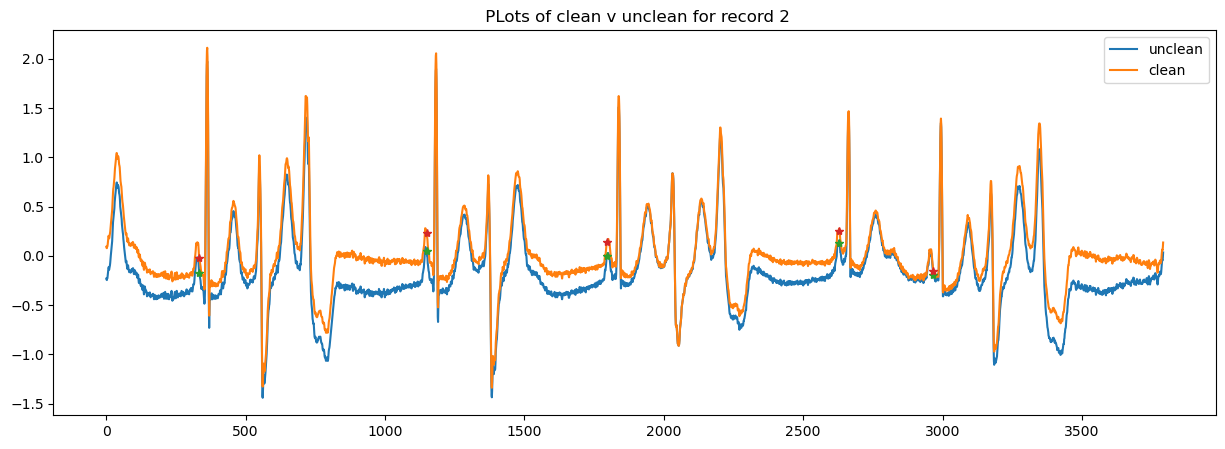

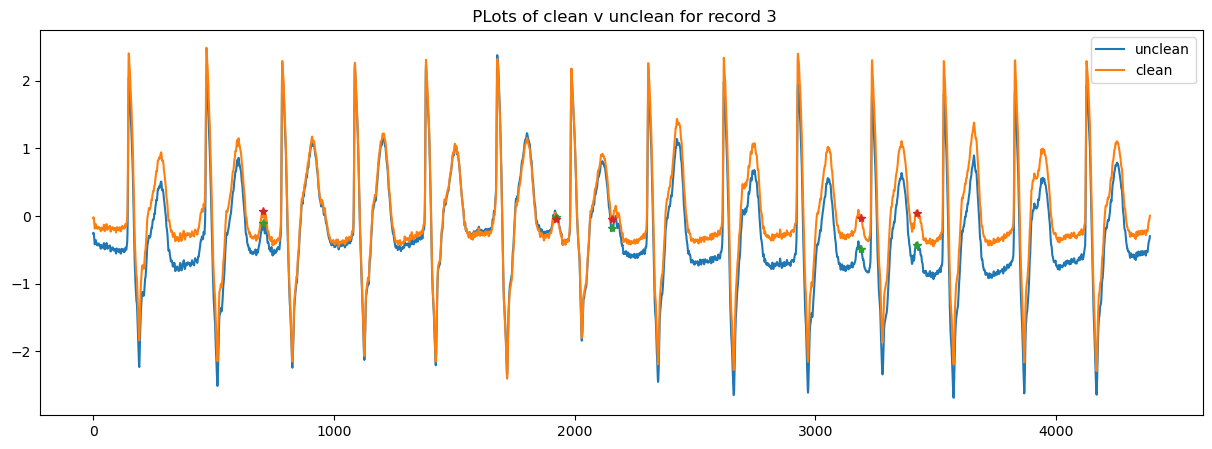

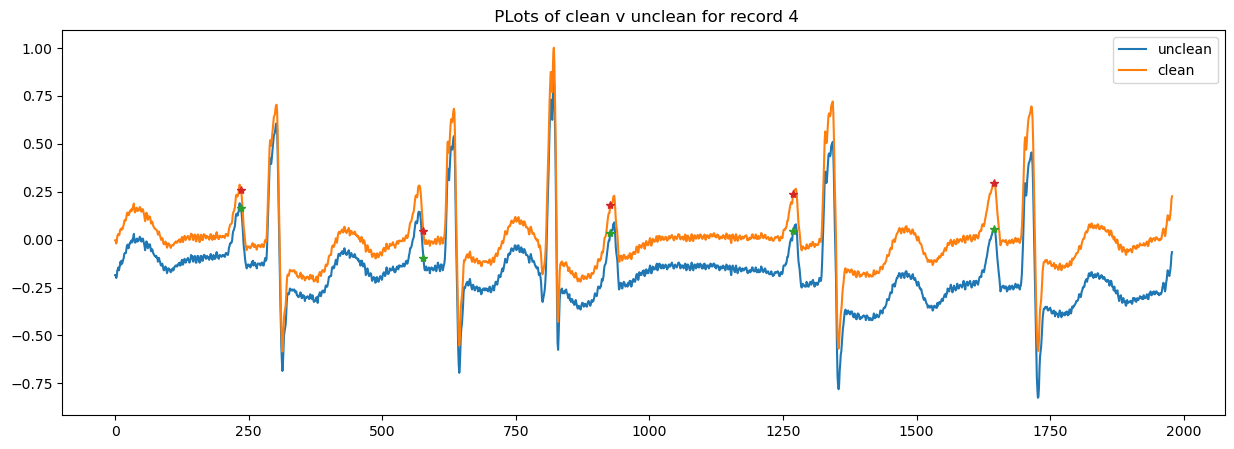

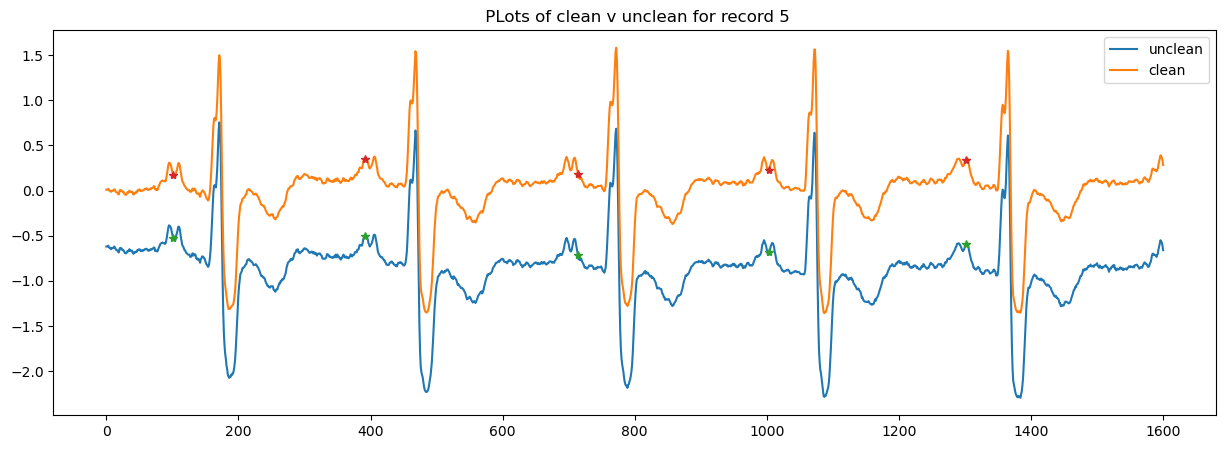

In [7]:
# clean the signals
def cleanTheSignals(signals):
    clean_signals = []
    
    for i in range(len(signals)):
        sig_clean = signals[i].copy()
        sig_clean = sp.filter_X(sig_clean,360,band=[0.5], btype='highpass',ftype='SOS')
        sig_clean = sp.filter_X(sig_clean,360,band=[150], btype='lowpass',ftype='SOS')
    
        clean_signals.append(sig_clean)

    return clean_signals

clean_signals = cleanTheSignals(signals)

for i in range(5):
    #plot signals against each other
    plt.figure(figsize = (15,5))
    plt.title(f' PLots of clean v unclean for record {i+1}')
    
    plt.plot(signals[i][:p_anns[i].sample[5]], label = 'unclean')
    plt.plot(clean_signals[i][:p_anns[i].sample[5]], label = 'clean')
    
    plt.plot(p_anns[i].sample[:5],signals[i][p_anns[i].sample[:5]],'*')
    plt.plot(p_anns[i].sample[:5],clean_signals[i][p_anns[i].sample[:5]],'*')
    
    plt.legend()

## Plot accuracy of P annotations

From the earlier plotting, we could see the R and P peak slightly being off, this section will just test if the annotations for P peak is off. The signal will be plotted by overlapping each other at the P peak annotation. We should see the peaks curve near the middle line.

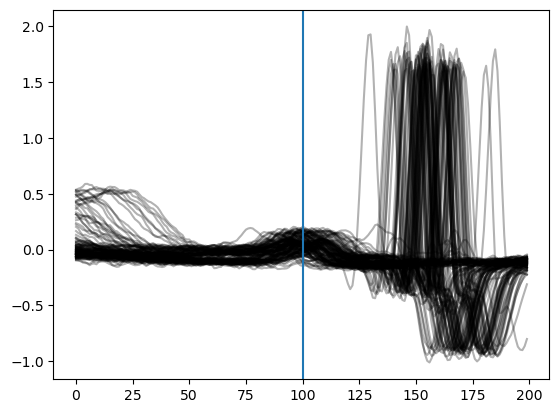

In [8]:
for i in range(len(p_anns[0].sample)):
  plt.plot(clean_signals[0][p_anns[0].sample[i] - 100 : p_anns[0].sample[i] +100], color = 'k', alpha = 0.3)
plt.axvline(100)

## Use peak algorithm for one signal

the plot for the P peak annotations had poor results as a lot of peaks were visible away from the vertical line. We use an algorithm to detect the peaks and visualise the results the same way as a direct comparison

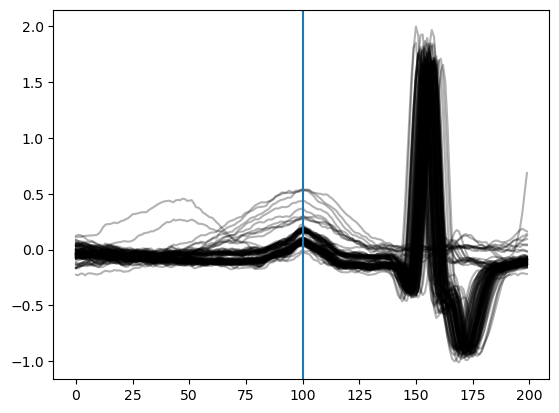

In [9]:
_, rpeaks = nk.ecg_peaks(clean_signals[0], sampling_rate=360)
rpks = rpeaks['ECG_R_Peaks']

# Delineate the ECG signal
_, waves_peak = nk.ecg_delineate(clean_signals[0], rpks, sampling_rate=360, method="peak")

pws = waves_peak['ECG_P_Peaks']

for i in range(len(pws)):
    if pws[i] not in [np.nan]:
        plt.plot(clean_signals[0][pws[i] - 100 : pws[i] +100], color = 'k', alpha = 0.3)
plt.axvline(100)

## Algorithm to convert all

the algorithm detector had better results than the annotations. Because of this finding, we will overwrite the initial P and R peak annotations, with the peaks the algorithm detected.

In [10]:
def FindP_peaks(signals, fs):
    p_anns =[]
    r_anns= []
    
    for i in range(len(signals)):
        _, rpeaks = nk.ecg_peaks(signals[i], sampling_rate=fs)
        rpks = rpeaks['ECG_R_Peaks']
        
        # Delineate the ECG signal
        _, waves_peak = nk.ecg_delineate(signals[i], rpks, sampling_rate=fs, method="peak")
        
        pws = waves_peak['ECG_P_Peaks']
    
        p_anns.append(pws)
        r_anns.append(rpks)

    return p_anns, r_anns

p_anns, r_anns = FindP_peaks(clean_signals, 360)

## Split signals into beats

This function will split the signal into singular beats as this is what our X input will be. The method will be finding all the R peaks, and slicing in between them to split into a beat

In [11]:
# split into beats
def SplitBeats(p_anns, r_anns, signals):
    #remove all nans
    for i in range(len(p_anns)):
        arr = np.array(p_anns[i])
        cleaned_arr = arr[~np.isnan(arr)] 
        p_anns[i] = cleaned_arr.astype(int).tolist()
        
    beats = []
    p_pks = []
    r_pks = []
    
    for i in range(len(signals)):
        rpks = np.array(r_anns[i], dtype=int)
        ppks = np.array(p_anns[i], dtype=int)
    
        
        #create split lines
        boundaries = np.zeros(len(rpks) + 1, dtype=int)
        for k in range(1, len(rpks)):
            boundaries[k] = (rpks[k - 1] + rpks[k]) // 2
    
        if (p for p in ppks if boundaries[j] <= p < boundaries[j+1]) in [np.nan]:
            print(f' tru and p is {p}')
    
    
       # split the beats and re align p and r peak
        for j in range(len(rpks)):
            beat = signals[i][boundaries[j]: boundaries[j+1]]
            beat = beat - np.mean(beat)
    
            #if there are no p peaks skip
            if len([p - boundaries[j] for p in ppks if boundaries[j] <= p < boundaries[j+1]]) == 0:
                continue
                
            beats.append(beat)
            r_pks.append(rpks[j] - boundaries[j])
            p_pks.append([p - boundaries[j] for p in ppks if boundaries[j] <= p < boundaries[j+1]])

    return beats, p_pks, r_pks

beats, p_pks, r_pks = SplitBeats(p_anns, r_anns, clean_signals)

/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide


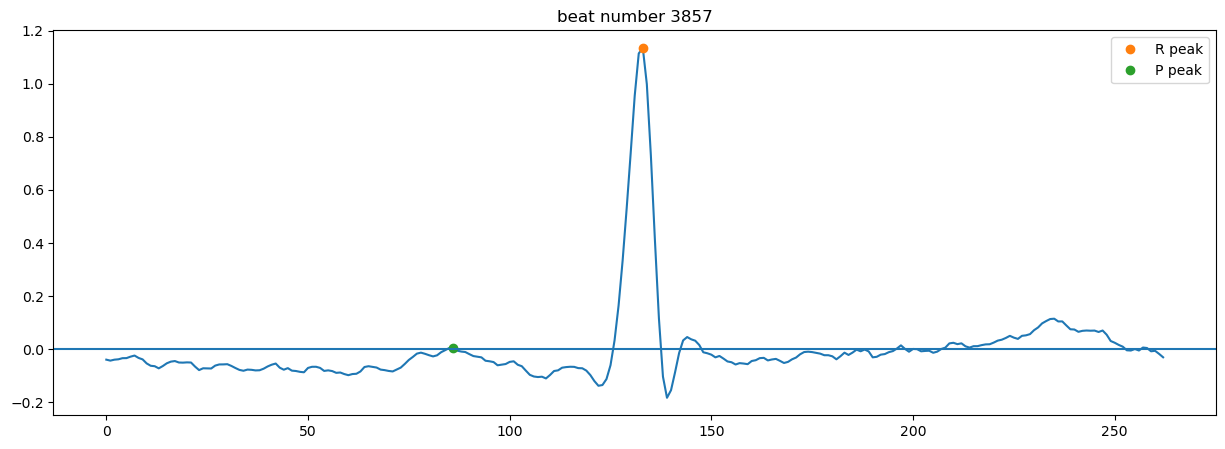

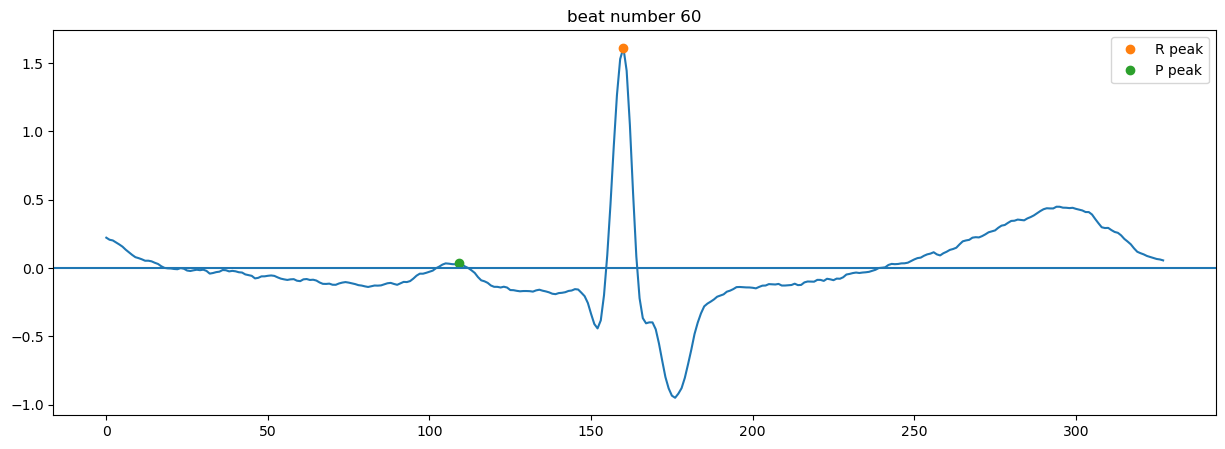

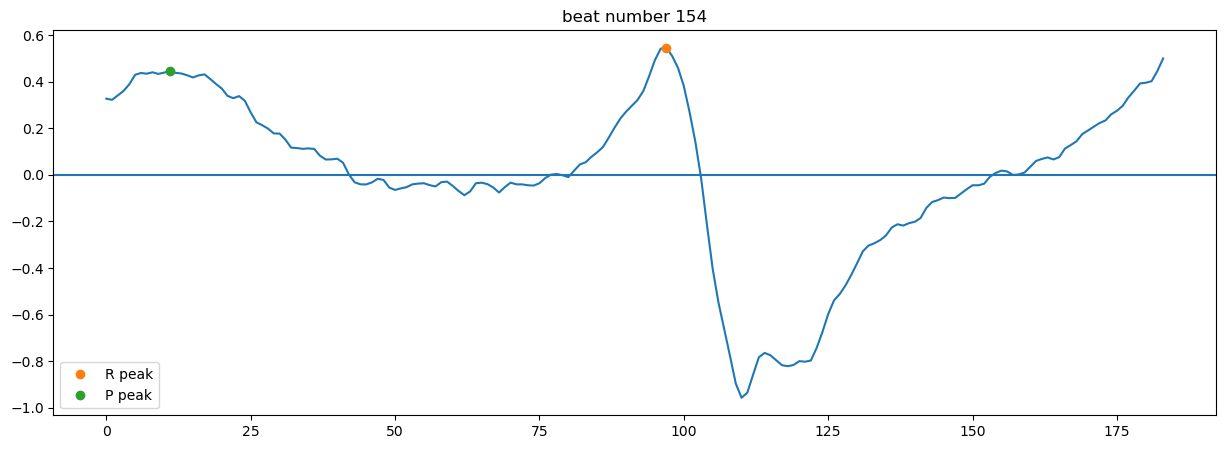

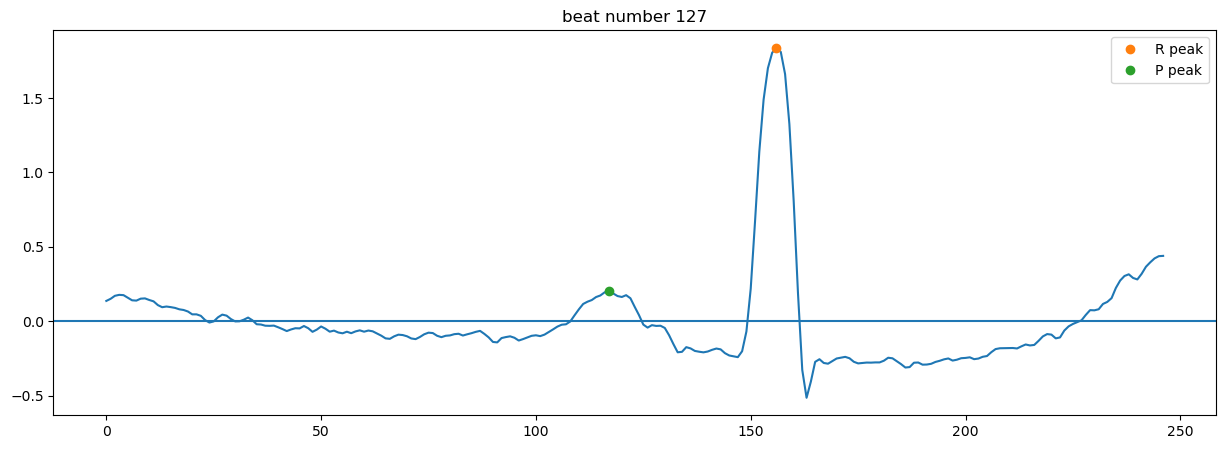

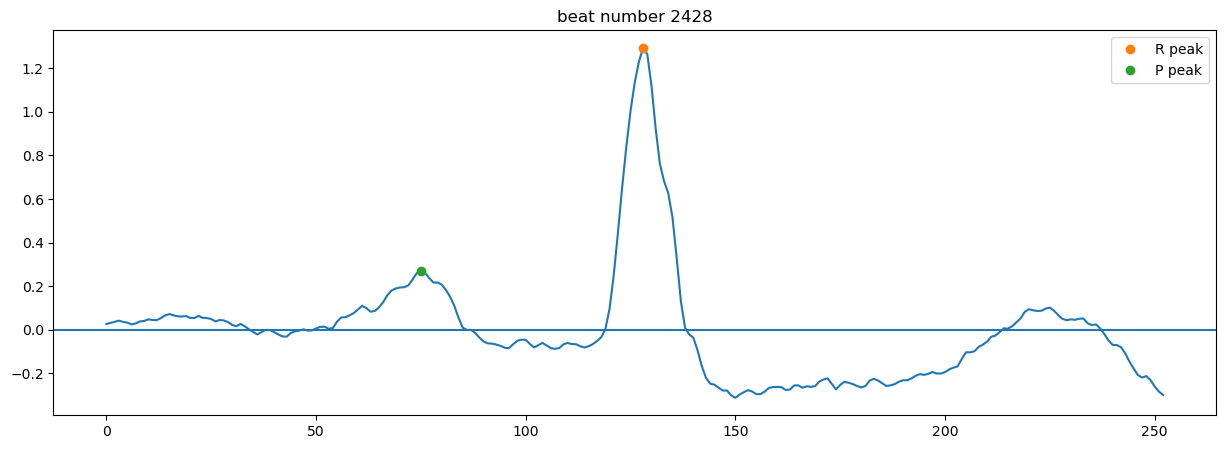

In [10]:
#print 5 random beats
#plot to view accuracy
rand_beat = np.random.randint(1, len(beats), size=5)

for i in rand_beat:
    plt.figure(figsize=(15, 5))
    plt.plot(beats[i])
    plt.plot(r_pks[i], beats[i][r_pks[i]], 'o', label='R peak')
    plt.plot(p_pks[i], beats[i][p_pks[i]], 'o', label='P peak')
    plt.title(f'beat number {i}')
    plt.axhline(0)
    plt.legend()

In [12]:
len(beats)

4617

## Split into train and test set

The X will simply be the beats. The y will be the height of the P peak, with the method of our splitting beats, this could result in a beat having 0, 1, or 2 P peaks. if it is 0, we do not add and if its 2 peaks, we only take the height of the first one.

As we split the beats, each will have a different shape, and for the data to be accepted by the model, we padded the end of data with 0s, the length of 0s depended on the data with the largest length, and simple every other data was padded to match tat length.

In [11]:
# split into X and y 

X = beats.copy()
y =[]

for i, p in enumerate(p_pks):
    if len(p) > 0:
        #take only the first p peak
        y.append(beats[i][p[0]])
    else:
        y.append(0.0)

In [12]:
# pad X values as they are different sizes
raw_lengths = [len(x) for x in X]
max_len = max(len(x) for x in X)
X = pad_sequences(
    X, maxlen=max_len, dtype="float32",
    padding="post", value=0.000
)[..., np.newaxis]   
y = np.array(y, dtype="float32")

In [13]:
indices = np.arange(len(p_pks))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, indices, test_size=0.2, random_state=42)
beats_ppks_train = [p_pks[i] for i in idx_train]
beats_ppks_test  = [p_pks[i] for i in idx_test]

beats_rpks_train = [r_pks[i] for i in idx_train]
beats_rpks_test  = [r_pks[i] for i in idx_test]

raw_lengths_train = [raw_lengths[i] for i in idx_train]
raw_lengths_test = [raw_lengths[i] for i in idx_test]


# Model Architecture

## Architecture

The model architecture consisted of multiple convolutional, maxPooling, Dropout and BatchNormalization layer. This was done to find the best balance between learning but not overtraining.

As we have padding, a mask was created to ignore all features learnt where the data is 0. As Max pooling and BatchNormalization decreased the data size, we had to also decrease the mask size, so we can multiply them at the end

In [14]:
# Inputs & mask
inp  = layers.Input(shape=(None, 1))
mask = tf.cast(tf.not_equal(inp, 0.0), tf.float32)  # shape=(batch, T, 1)
x    = inp

# Conv‐pool blocks
x    = layers.Conv1D(64, 5, strides=2, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-5))(x)
mask = layers.MaxPooling1D(pool_size=2, strides=2, padding="same")(mask)
x    = layers.Dropout(0.1)(x)
x    = layers.BatchNormalization()(x)
x    = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)

x    = layers.Conv1D(128, 5, strides=2, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-6))(x)
mask = layers.MaxPooling1D(pool_size=2, strides=2, padding="same")(mask)
x    = layers.Dropout(0.2)(x)
x    = layers.BatchNormalization()(x)
x    = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)

x    = layers.Conv1D(256, 5, strides=1, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-7))(x)
x    = layers.Dropout(0.3)(x)
x    = layers.BatchNormalization()(x)
x    = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)

# apply mask
x = layers.Multiply()([x, mask])

# global pooling
x = layers.GlobalAveragePooling1D()(x)

#dense layers
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)

out = layers.Dense(1, activation="linear")(x)

# compile
model = models.Model(inputs=inp, outputs=out)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"]
)

In [15]:
model.load_weights('ecg_regression_trained.h5')

## Model plots

show accuracy of model 

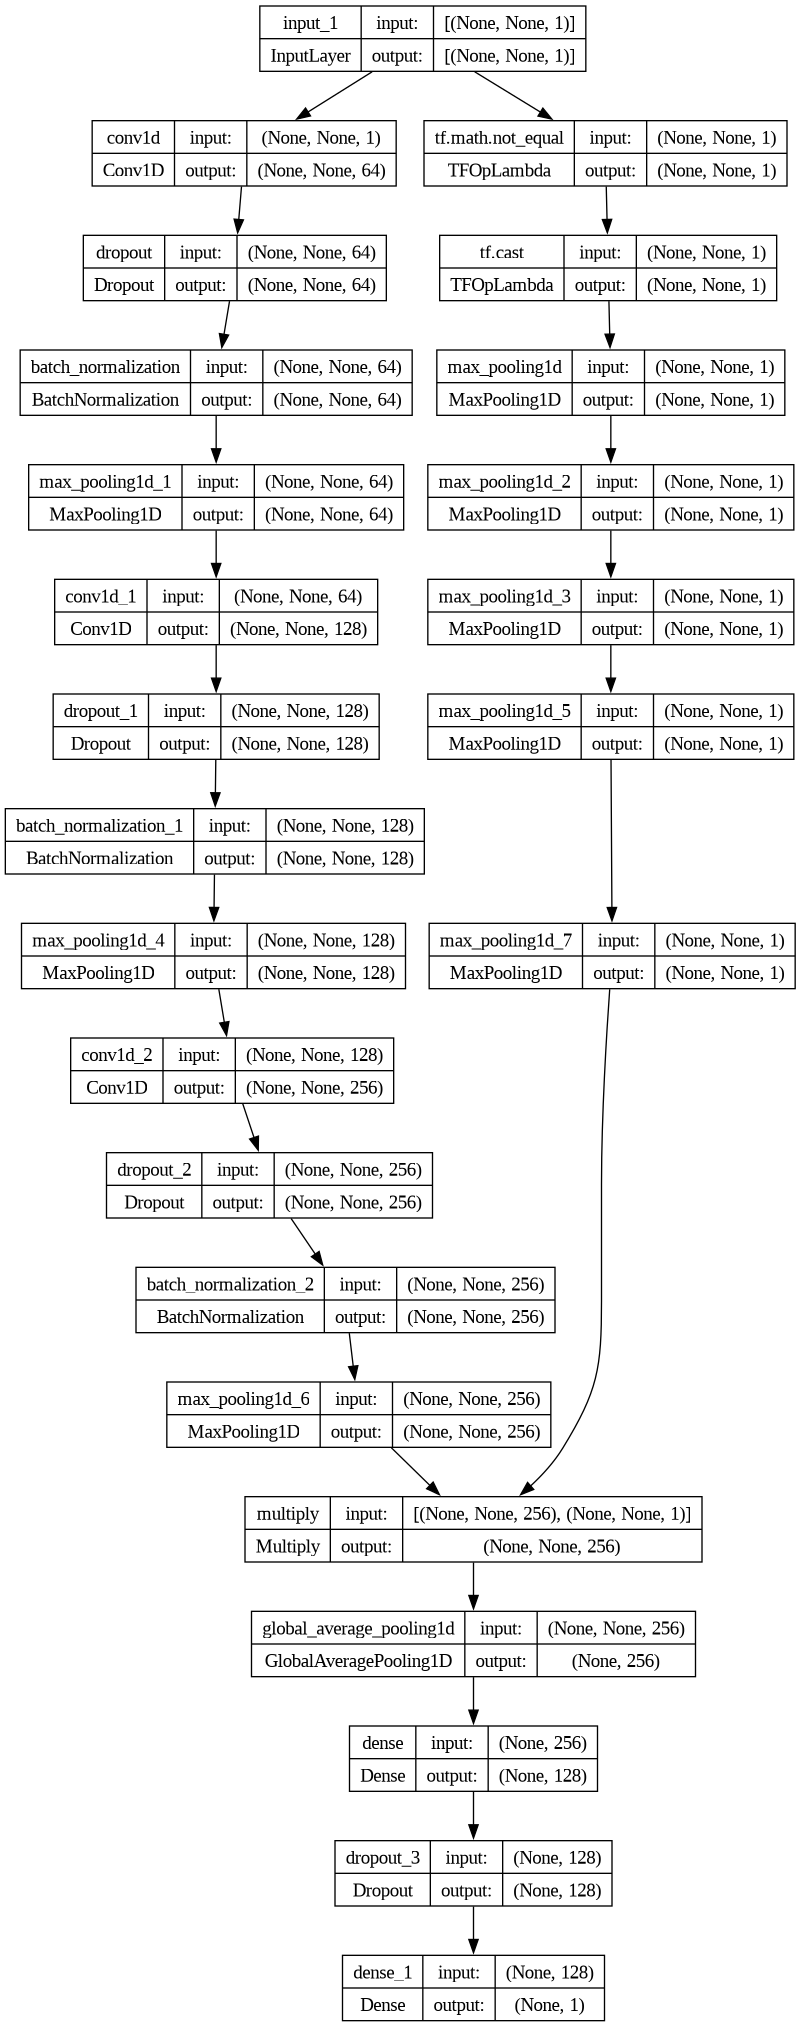

In [16]:
dot_img_file = 'model_1.png'
plot_model(model, to_file=dot_img_file,  show_shapes=True)

In [17]:
with open('training_history.json') as f:
    hist = json.load(f)

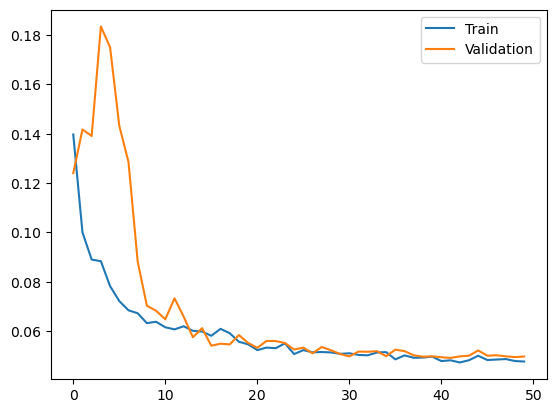

In [18]:
plt.plot(hist['mae'], label = 'Train')
plt.plot(hist['val_mae'], label = 'Validation')
plt.legend()


In [19]:

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))


29/29 [==============================] - 1s 11ms/step
MAE: 0.05136052146553993
MSE: 0.007969610393047333
R2:  0.7196192741394043


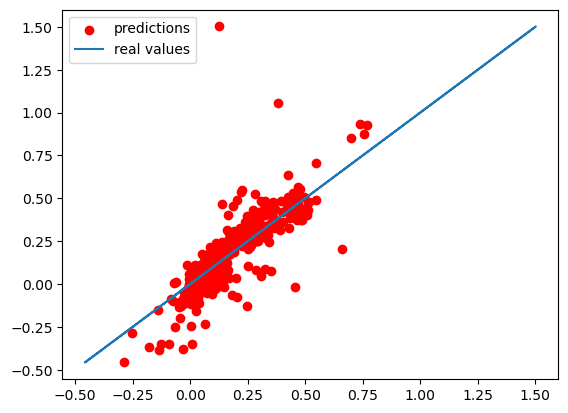

In [20]:
plt.scatter(y_pred, y_test, color = 'red', label = 'predictions')
plt.plot(y_test, y_test, label = 'real values')
plt.legend()

# Saliency maps

## Definitions for saliency maps

This section will hold what all the different types of saliency maps will need. The score, samples, labels, peaks and predictions will be defined here in order to not re use the same code multiple times

In [21]:
#find the error diff for each prediction and its real values
errors = np.abs(y_pred.flatten() - y_test.flatten())

#find the 5 lowest error diff, and assign its signal, label, p peak and prediction
top5_idx = np.argsort(errors)[:5]
samples = np.stack([X_test[i] for i in top5_idx])
labels = np.stack([y_test[i] for i in top5_idx])
peaks = np.stack([beats_ppks_test[i] for i in top5_idx])
preds = np.stack([y_pred[i] for i in top5_idx])
# this variable is done so we can cut out the padding when plotting
xlim_length = [raw_lengths_test[i] for i in top5_idx]

#same thing but this time for the 5 worst predictions
bottom5_idx = np.argsort(-errors)[:5]
samples_bottom = np.stack([X_test[i] for i in bottom5_idx])
labels_bottom = np.stack([y_test[i] for i in bottom5_idx])
peaks_bottom = np.stack([beats_ppks_test[i] for i in bottom5_idx])
preds_bottom = np.stack([y_pred[i] for i in bottom5_idx])
xlim_length_bottom = [raw_lengths_test[i] for i in bottom5_idx]


#each saliency map needs a score values
def score(inputs):
    return model(inputs)

# def score(output):
#     return output[:, 0]  


## Vanilla saliency

/tmp/ipykernel_6694/543413360.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


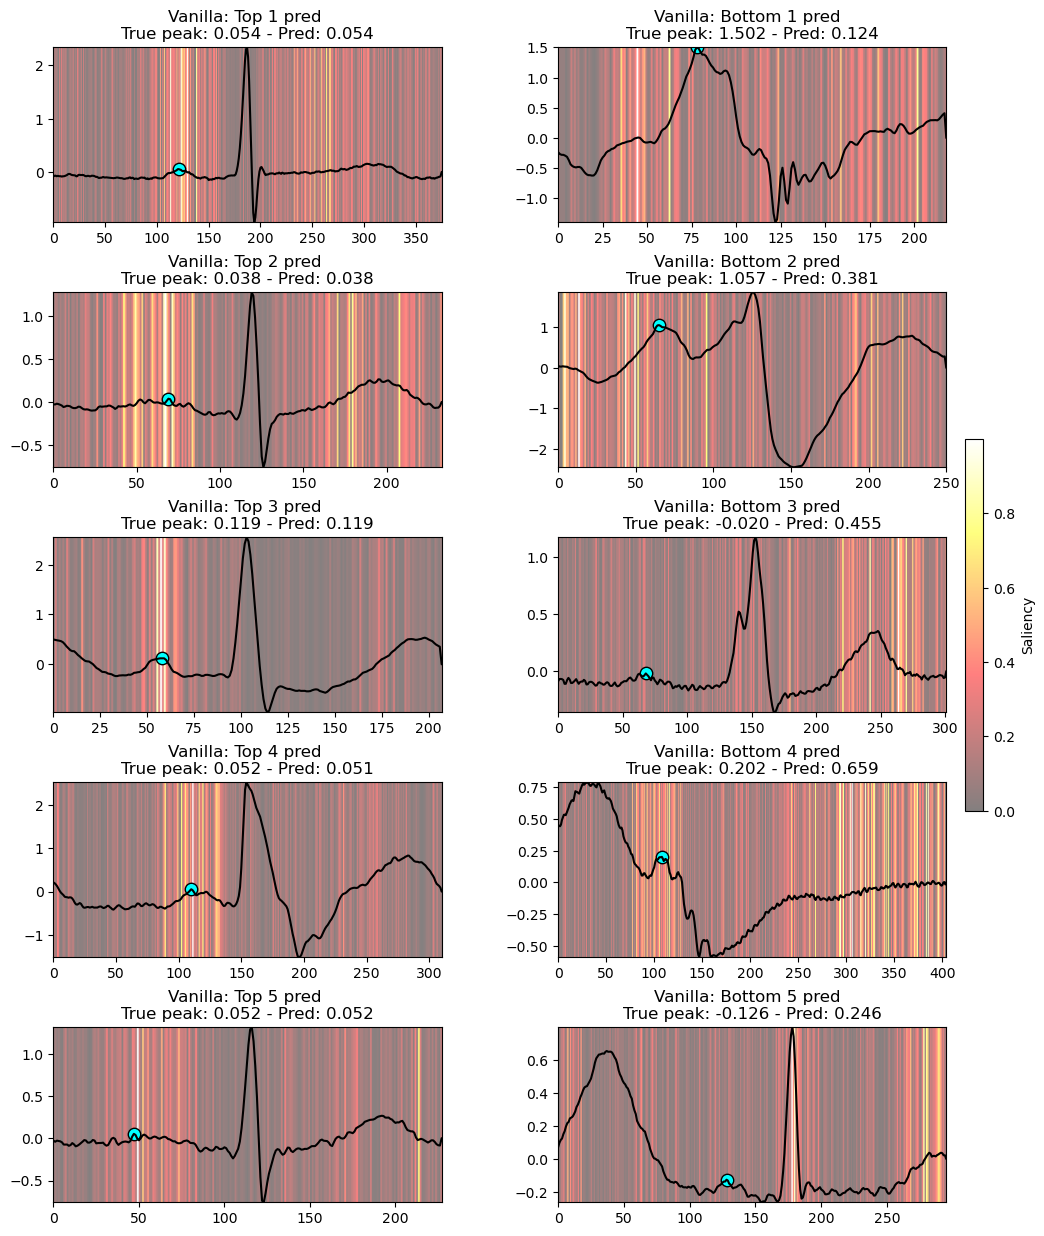

In [22]:
#create vanilla saliency instance
van_saliency = Saliency(model, model_modifier=None, clone=True)

#create subplots to format the plots side by side
fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

#------------TOP 5----------------
vanilla_saliency_map = van_saliency(score, samples)
for i in range(len(samples)):
    ax = axes[i, 0] # plots on left side
    im = ax.imshow(
    np.vstack([vanilla_saliency_map[i], vanilla_saliency_map[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower') # creates a heatmap style over lay
    ax.plot(samples[i, :, 0], color='black', label='ECG') # plot the signal
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak') # Mark the P peak
    ax.set_title(f"Vanilla: Top {i+1} pred \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}") # title each plot 
    ax.set_xlim(0, xlim_length[i]) #cut off plot when padding starts

#---------------BOTTOM 5-----------------------
#Same as before but the variables have been changed for the bottom 5 predictions
vanilla_saliency_map_bottom = van_saliency(score, samples_bottom)
for i in range(len(samples_bottom)):
    ax = axes[i, 1] #plots on the right side
    im = ax.imshow(
    np.vstack([vanilla_saliency_map_bottom[i], vanilla_saliency_map_bottom[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"Vanilla: Bottom {i+1} pred  \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])
  
#plot one colour bar that represents all
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

## SmoothGrad

/tmp/ipykernel_6694/2708602798.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


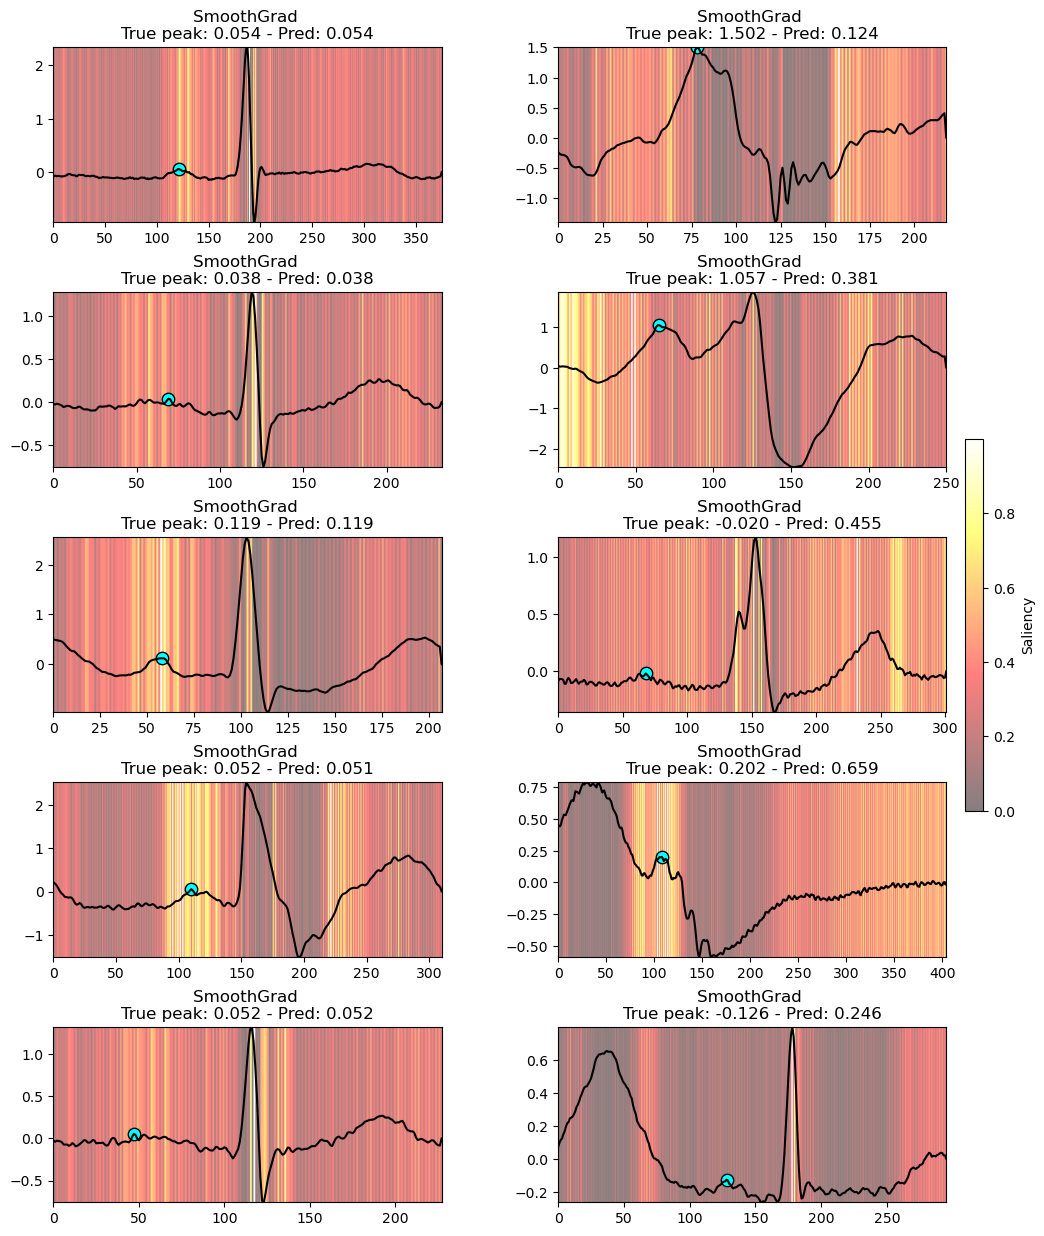

In [23]:
# Create smooth grad saliency instance
sg_saliency = Saliency(model, model_modifier=None, clone=True)

fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)


#-------------TOP 5--------------------------
sg_saliency_map = sg_saliency(score,samples,smooth_samples=500,  smooth_noise=0.05)  #generate saliency map with the parameters

# Any features on padding that might come up as salient has been reduced to 0. (Possibly not needed anymore as plot cuts at padding now)
mask_np = (samples != 0).astype(np.float32)  
mask_np = np.squeeze(mask_np, axis=-1)    
sg_saliency_map[mask_np == 0] = 0

for i in range(len(samples)):
    ax = axes[i, 0] #plot on left side
    im = ax.imshow(
    np.vstack([sg_saliency_map[i], sg_saliency_map[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower') #plots saliency like a heatmap
    ax.plot(samples[i, :, 0], color='black', label='ECG') #plots ECG signal
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak') #marks P peak
    ax.set_title(f"SmoothGrad \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0, xlim_length[i]) #cuts off at padding

#-------------------------BOTTOM 5-----------------------------------------

sg_saliency_map_bottom = sg_saliency(score, samples_bottom, smooth_samples=500, smooth_noise=0.05) # keep the parameters the same

mask_np = (samples_bottom != 0).astype(np.float32)  
mask_np = np.squeeze(mask_np, axis=-1)    
sg_saliency_map_bottom[mask_np == 0] = 0

for i in range(len(samples_bottom)):
    ax = axes[i, 1] #prints on right side
    im = ax.imshow(
    np.vstack([sg_saliency_map_bottom[i], sg_saliency_map_bottom[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
    origin='lower')
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"SmoothGrad \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

## GradCAM

/tmp/ipykernel_6694/710046209.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/tmp/ipykernel_6694/710046209.py:69: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1500 with 11 Axes> than <Figure size 1200x1500 with 11 Axes> which fig.colorbar is called on.


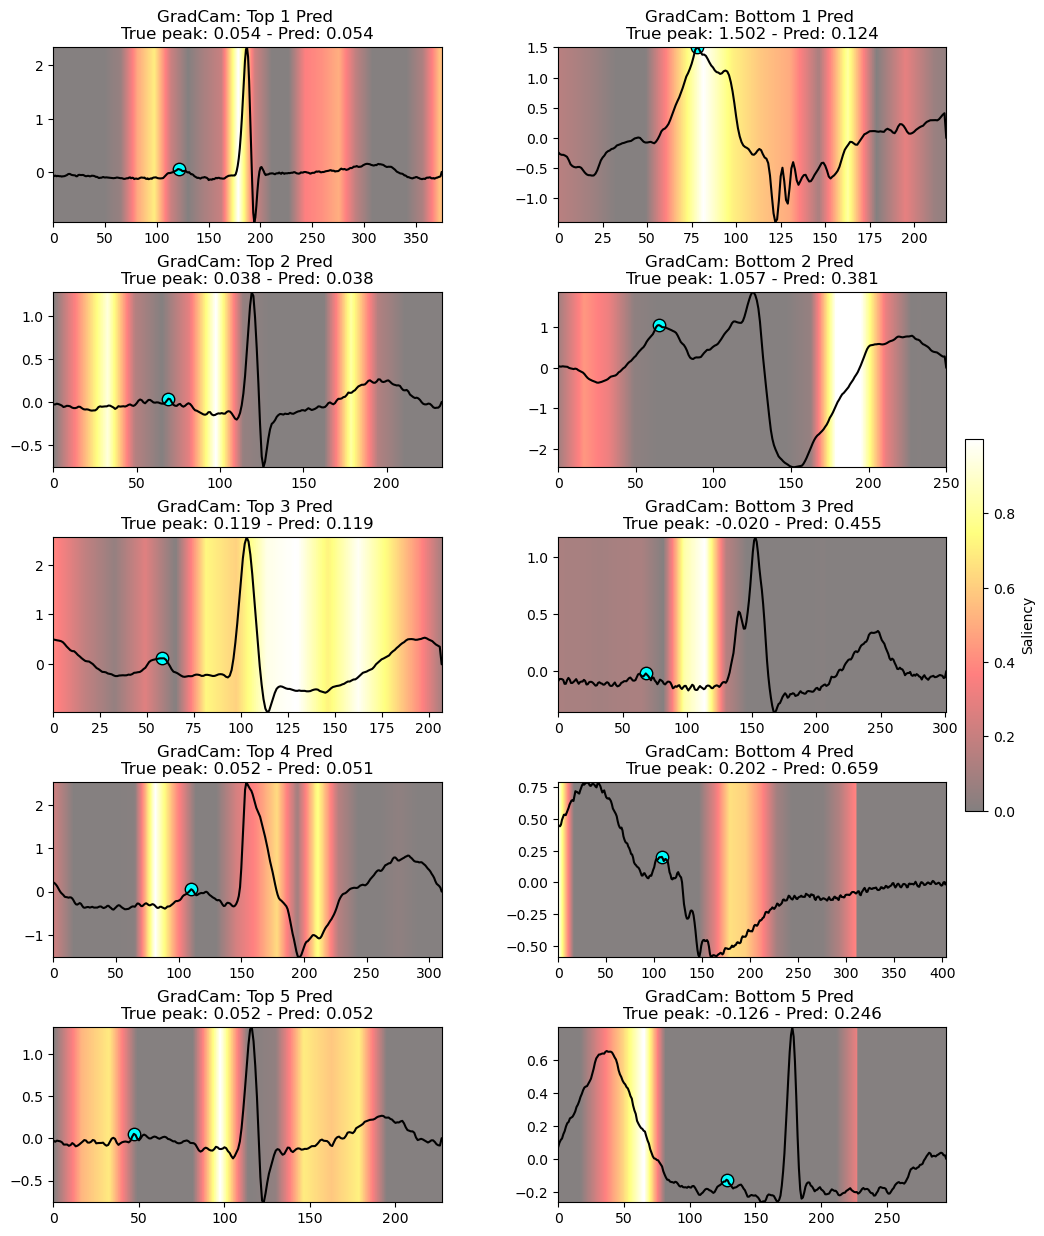

In [24]:
# Get the penultimate Conv1D layer (can use index or layer name)
penultimate_layer = 'conv1d_2'

# Create GradCAM object
gradcam = Gradcam(model, model_modifier=None, clone=True)

fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

#-----------------------TOP 5--------------------------------------
# Generate cam
cam_grad = gradcam(score, samples, penultimate_layer=penultimate_layer)

# Any features on padding that might come up as salient has been reduced to 0. (Possibly not needed anymore as plot cuts at padding now)
mask_cam_grad = (samples != 0).astype(np.float32)  # 1 where real data, 0 where padding
mask_cam_grad = np.squeeze(mask_cam_grad, axis=-1)       # Remove channel dimension if present

cam_grad[mask_cam_grad == 0] = 0

cam_resized_grad = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam_grad
])

for i in range(len(samples)):
    ax = axes[i, 0]
    ax.imshow(
    np.vstack([cam_resized_grad[i], cam_resized_grad[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"GradCam: Top {i+1} Pred \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0, xlim_length[i])


#-----------------------BOTTOM 5--------------------------------------

cam_grad_bottom = gradcam(score, samples_bottom, penultimate_layer=penultimate_layer)

# Any features on padding that might come up as salient has been reduced to 0. (Possibly not needed anymore as plot cuts at padding now)
mask_cam_grad_bottom = (samples != 0).astype(np.float32)  # 1 where real data, 0 where padding
mask_cam_grad_bottom = np.squeeze(mask_cam_grad_bottom, axis=-1)       # Remove channel dimension if present
cam_grad_bottom[mask_cam_grad_bottom == 0] = 0

cam_grad_resized_bottom = np.array([
    scipy.ndimage.zoom(c, samples_bottom.shape[1] / c.shape[0], order=1)
    for c in cam_grad_bottom
])

for i in range(len(samples_bottom)):
    ax = axes[i, 1]
    ax.imshow(
    np.vstack([cam_grad_resized_bottom[i], cam_grad_resized_bottom[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"GradCam: Bottom {i+1} Pred \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])


cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

## GradCAM ++

/tmp/ipykernel_6694/915935850.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/tmp/ipykernel_6694/915935850.py:68: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1500 with 11 Axes> than <Figure size 1200x1500 with 11 Axes> which fig.colorbar is called on.


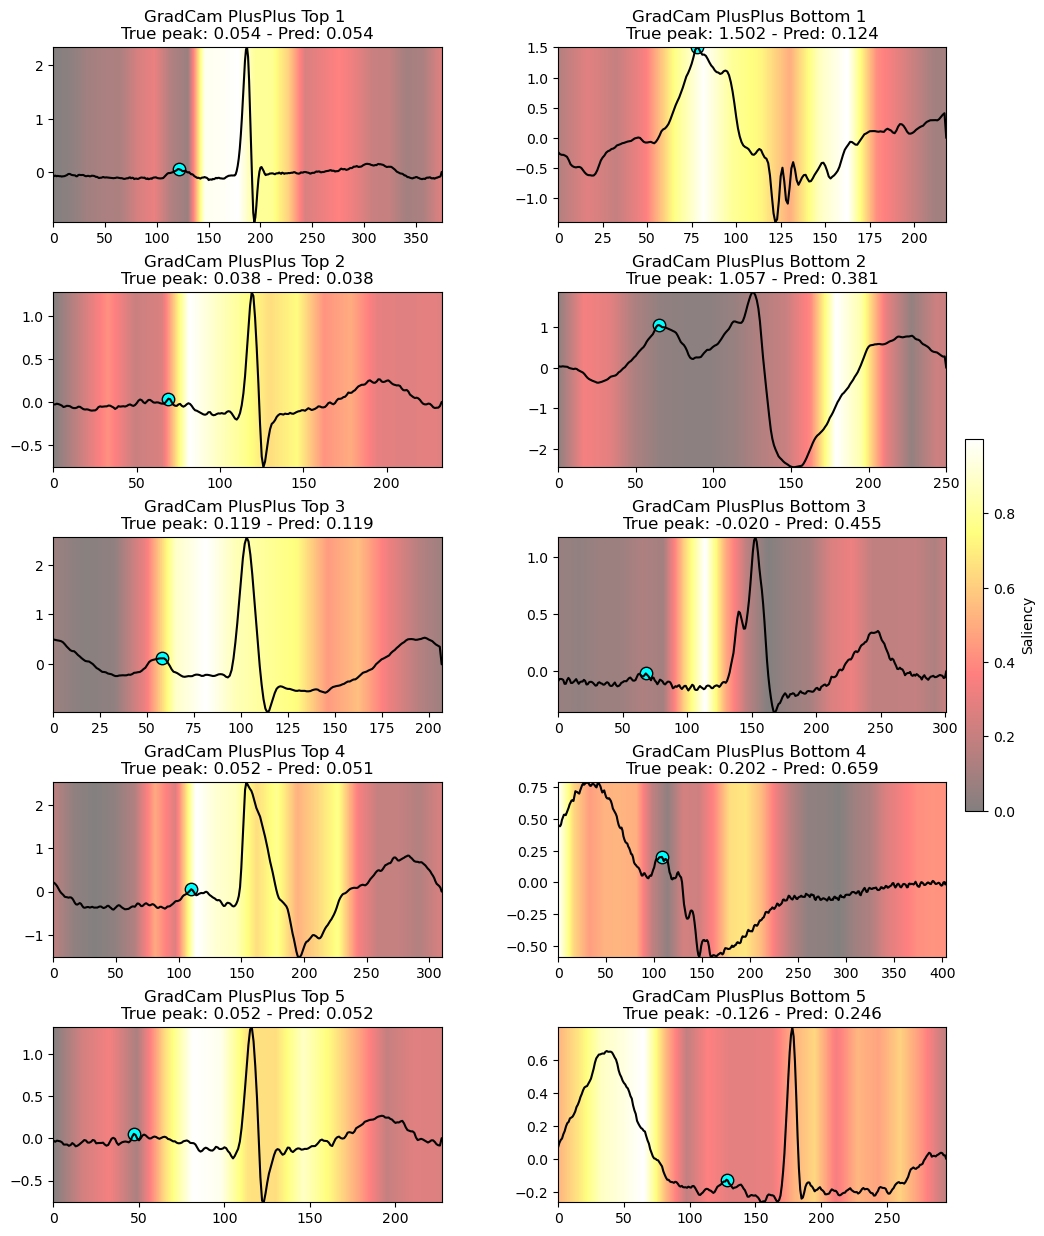

In [25]:
# Create GradCAM++ object
gradcam_plus = GradcamPlusPlus(model, model_modifier=None, clone=True)

fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

#-----------------TOP 5--------------------------

# Generate heatmap with GradCAM++
cam_plus = gradcam_plus(score, samples, penultimate_layer =  penultimate_layer)


mask_cam_plus = (samples != 0).astype(np.float32) 
mask_cam_plus = np.squeeze(mask_cam_plus, axis=-1)
cam_plus[mask_cam_plus == 0] = 0

cam_plus_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam_plus
])

for i in range(len(samples)):
    ax = axes[i, 0]
    ax.imshow(
    np.vstack([cam_plus_resized[i], cam_plus_resized[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    
    ax.set_title(f"GradCam PlusPlus Top {i+1} \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0, xlim_length[i])

#-----------------------------BOTTOM 5-------------------------------

# Generate heatmap with GradCAM++
cam_plus_bottom = gradcam_plus(score, samples_bottom, penultimate_layer =  penultimate_layer)

# After computing sg_saliency_map
mask_cam_plus_bottom = (samples_bottom != 0).astype(np.float32)  # 1 where real data, 0 where padding
mask_cam_plus_bottom = np.squeeze(mask_cam_plus_bottom, axis=-1)       # Remove channel dimension if present
cam_plus_bottom[mask_cam_plus_bottom == 0] = 0

cam_plus_resized_bottom = np.array([
    scipy.ndimage.zoom(c, samples_bottom.shape[1] / c.shape[0], order=1)
    for c in cam_plus_bottom
])


for i in range(len(samples)):
    ax = axes[i, 1]
    ax.imshow(
    np.vstack([cam_plus_resized_bottom[i], cam_plus_resized_bottom[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    
    ax.set_title(f"GradCam PlusPlus Bottom {i+1} \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

## ScoreCAM

40/40 [==============================] - 0s 1ms/step


/tmp/ipykernel_6694/4215900287.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/tmp/ipykernel_6694/4215900287.py:54: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1500 with 11 Axes> than <Figure size 1200x1500 with 11 Axes> which fig.colorbar is called on.


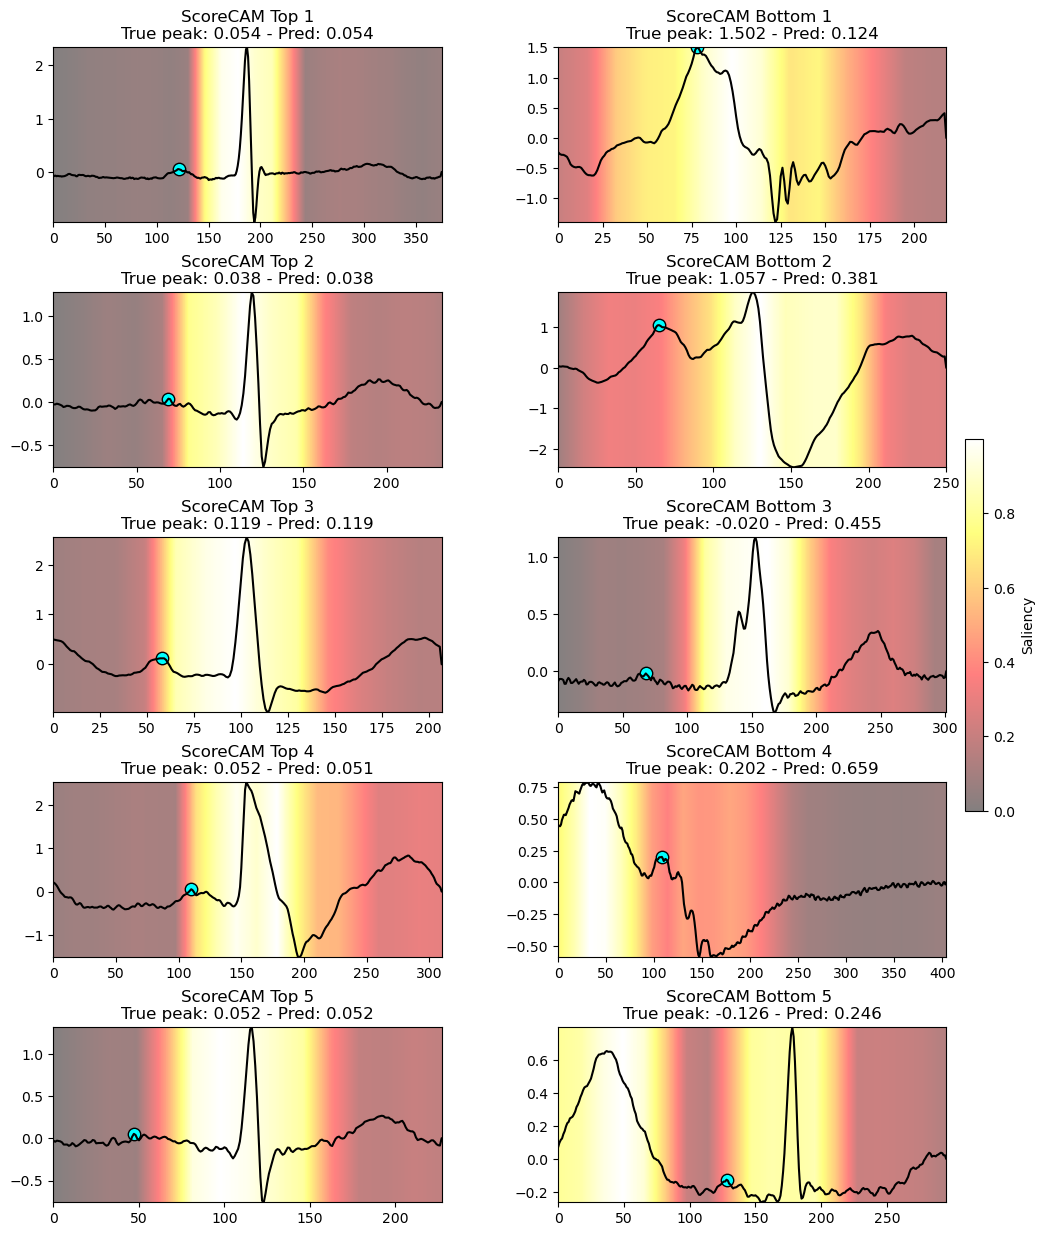

In [26]:
# Create ScoreCAM object
scorecam = Scorecam(model)

fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

#-------------------------------TOP 5-----------------------
# Generate heatmap with ScoreCAM
cam = scorecam(score, samples, penultimate_layer= penultimate_layer)

cam_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam
])

for i in range(len(samples)):
    ax = axes[i, 0]
    ax.imshow(
        np.vstack([cam_resized[i], cam_resized[i]]), 
        cmap='hot', aspect='auto', alpha=0.5,
        extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
        origin='lower'
    )
    ax.plot(samples[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"ScoreCAM Top {i+1}\nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0, xlim_length[i])


#-----------------------BOTTOM 5-------------------
cam_bottom = scorecam(score, samples_bottom, penultimate_layer= penultimate_layer)

cam_resized_bottom = np.array([
    scipy.ndimage.zoom(c, samples_bottom.shape[1] / c.shape[0], order=1)
    for c in cam_bottom
])


for i in range(len(samples_bottom)):
    ax = axes[i, 1]
    ax.imshow(
        np.vstack([cam_resized_bottom[i], cam_resized_bottom[i]]), 
        cmap='hot', aspect='auto', alpha=0.5,
        extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
        origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"ScoreCAM Bottom {i+1} \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

## Faster ScoreCAM

1/4 [======>.......................] - ETA: 0s

/tmp/ipykernel_6694/250961738.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


4/4 [==============================] - 0s 79ms/step


/tmp/ipykernel_6694/250961738.py:56: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1500 with 11 Axes> than <Figure size 1200x1500 with 11 Axes> which fig.colorbar is called on.


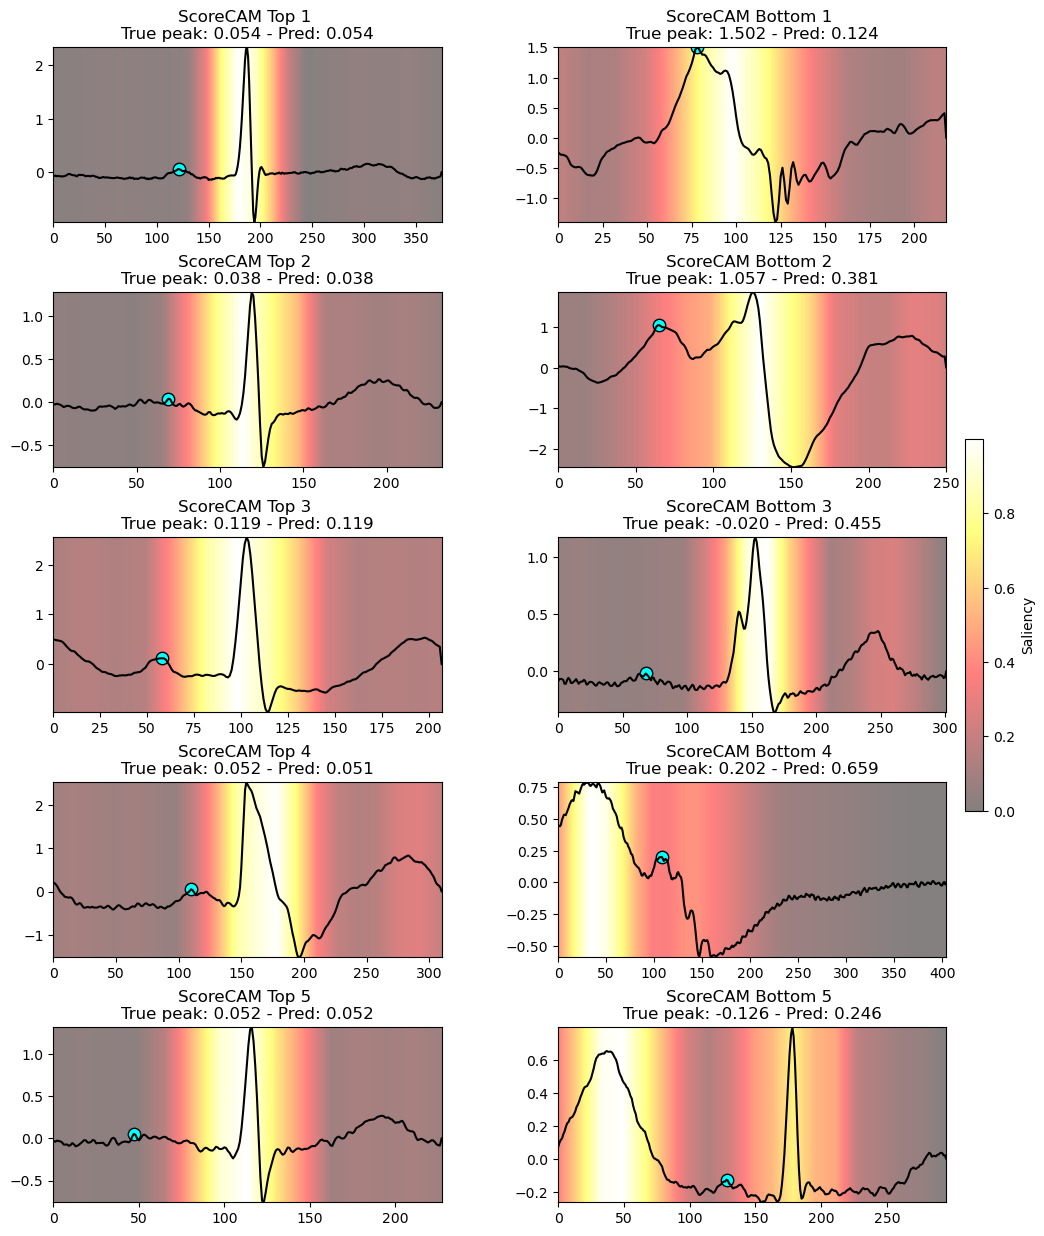

In [27]:
# Create ScoreCAM object
scorecam = Scorecam(model)

fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)


#---------------------TOP 5-----------------------
cam = scorecam(score, samples, penultimate_layer= penultimate_layer,  max_N=10)

cam_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam
])


for i in range(len(samples)):
    ax = axes[i,0]
    ax.imshow(
        np.vstack([cam_resized[i], cam_resized[i]]), 
        cmap='hot', aspect='auto', alpha=0.5,
        extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
        origin='lower'
    )
    ax.plot(samples[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"ScoreCAM Top {i+1} \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0,xlim_length[i])

#----------------------BOTTOM 5-----------------------------

# Generate heatmap with ScoreCAM
cam_bottom = scorecam(score, samples_bottom, penultimate_layer= penultimate_layer,  max_N=10)

cam_resized_bottom = np.array([
    scipy.ndimage.zoom(c, samples_bottom.shape[1] / c.shape[0], order=1)
    for c in cam_bottom
])

for i in range(len(samples_bottom)):
    ax = axes[i,1]
    ax.imshow(
        np.vstack([cam_resized_bottom[i], cam_resized_bottom[i]]), 
        cmap='hot', aspect='auto', alpha=0.5,
        extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
        origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"ScoreCAM Bottom {i+1} \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0,xlim_length_bottom[i])


cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

## Guided BackPropagation

/tmp/ipykernel_6694/3268863775.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


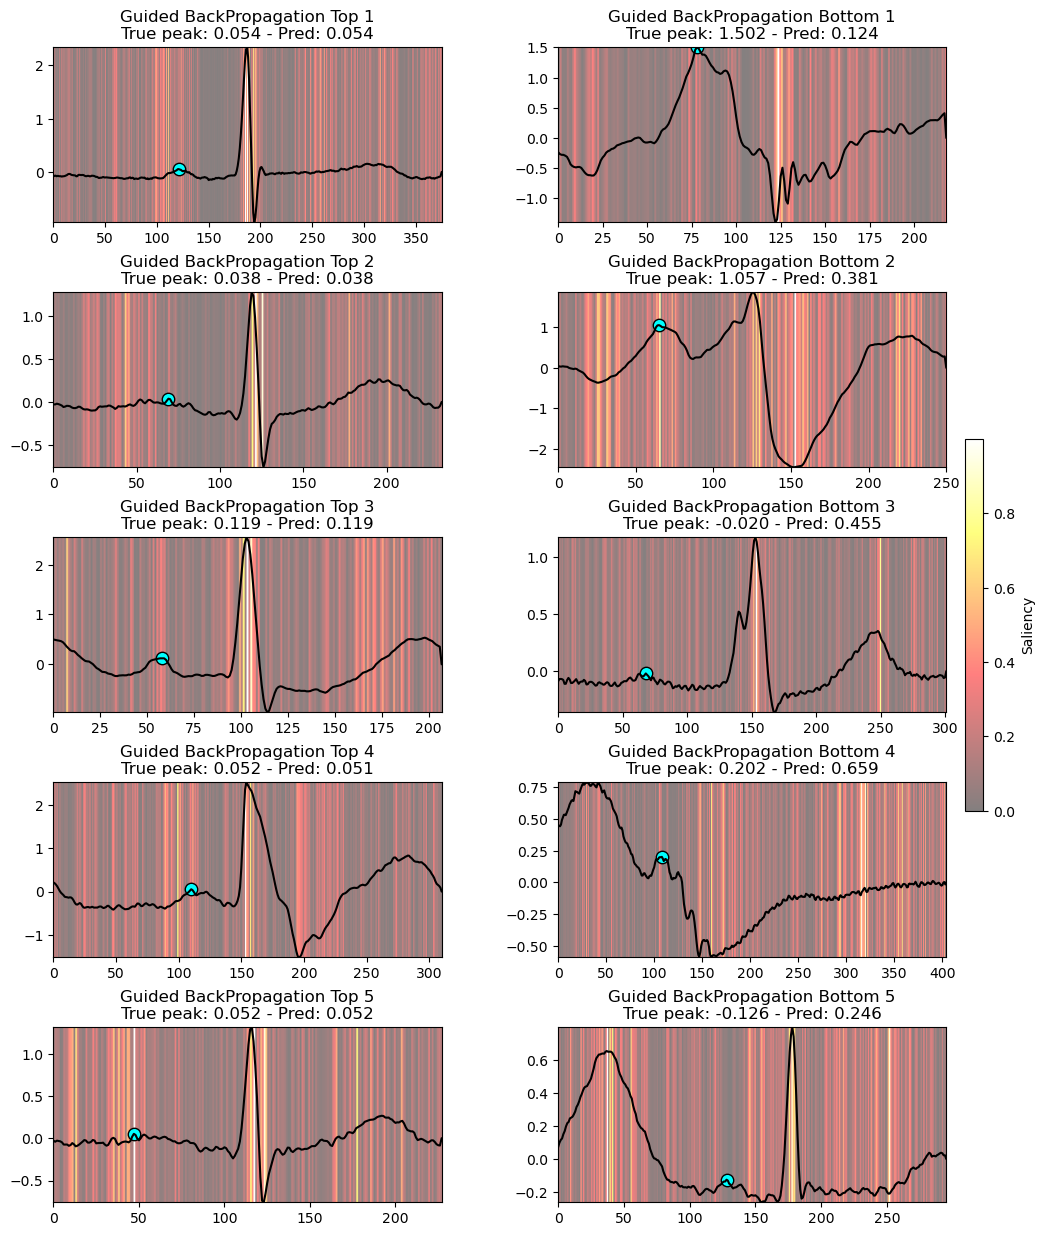

In [28]:
gb_saliency = Saliency(model, model_modifier=GuidedBackpropagation(), clone=True)

fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

#-------------------TOP 5--------------------------

gb_saliency_map = gb_saliency(score, samples)

for i in range(len(samples)):
    ax = axes[i, 0]
    im = ax.imshow(
    np.vstack([gb_saliency_map[i], gb_saliency_map[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"Guided BackPropagation Top {i+1}\nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0,xlim_length[i])

#-----------------------BOTTOM 5-------------------------
gb_saliency_map_bottom = gb_saliency(score, samples_bottom)

for i in range(len(samples_bottom)):
    ax = axes[i, 1]
    im = ax.imshow(
    np.vstack([gb_saliency_map_bottom[i], gb_saliency_map_bottom[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"Guided BackPropagation Bottom {i+1}\nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0,xlim_length_bottom[i])
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

## Guided GradCAM

/tmp/ipykernel_6694/25277134.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


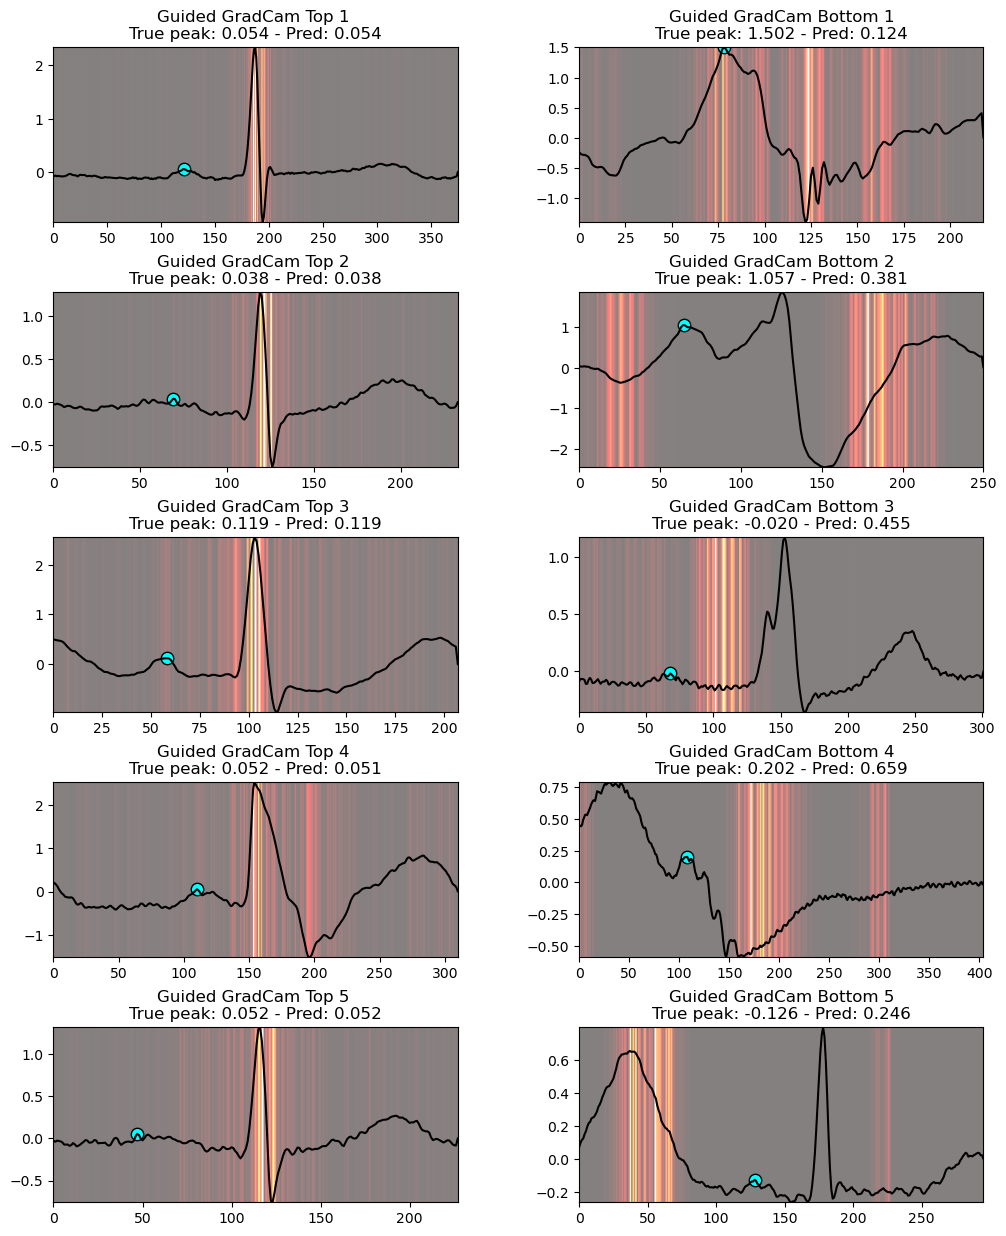

In [29]:
fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

#-----------------------TOP 5------------------------

guided_gradcam = gb_saliency_map * cam_resized
for i in range(len(samples)):
    ax = axes[i,0]
    ax.imshow(
    np.vstack([guided_gradcam[i], guided_gradcam[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak') 
    ax.set_title(f"Guided GradCam Top {i+1} \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0, xlim_length[i])
    
#-----------------BOTTOM 5-------------------------

guided_gradcam_bottom = gb_saliency_map_bottom * cam_grad_resized_bottom
for i in range(len(samples_bottom)):
    ax = axes[i,1]
    ax.imshow(
    np.vstack([guided_gradcam_bottom[i], guided_gradcam_bottom[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak') 
    ax.set_title(f"Guided GradCam Bottom {i+1}\nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])

## Average Saliency maps

In [31]:
#find index of top 100 predictions
top100_idx = np.argsort(errors)[:100]
#gather the signals
signals_top100 = X_test[top100_idx] 
#find their r peaks
r_peaks = [beats_rpks_test[i] for i in top100_idx]

#get saliency for each technqiue on the top 100
vanilla_saliency_map_avg = van_saliency(score, signals_top100)
sg_saliency_map_avg = sg_saliency(score, signals_top100, smooth_samples=20, smooth_noise=0.20) 
cam_grad_avg = gradcam(score, signals_top100, penultimate_layer=penultimate_layer)
cam_plus_avg = gradcam_plus(score, signals_top100, penultimate_layer =  penultimate_layer)
cam_score_avg = scorecam(score, signals_top100, penultimate_layer= penultimate_layer)
cam_fastscore_avg = scorecam(score, signals_top100, penultimate_layer= penultimate_layer,  max_N=10)
gb_saliency_map_avg = gb_saliency(score, signals_top100)
guided_gradcam_avg = gb_saliency_map_avg * cam_grad_avg

all_avg_saliency = [vanilla_saliency_map_avg, sg_saliency_map_avg, cam_grad_avg, cam_plus_avg, cam_score_avg, cam_fastscore_avg, gb_saliency_map_avg, guided_gradcam_avg]
title_sal = ['Vanilla', 'SmoothGrad', 'GradCam', 'GradCamPlus', 'ScoreCam', 'Faster ScoreCam', 'Guided BackPropagation', 'Guided GradCam']

175/175 [==============================] - 0s 1ms/step


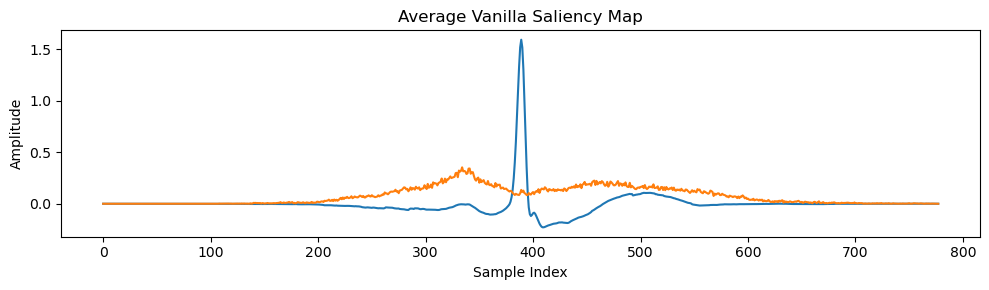

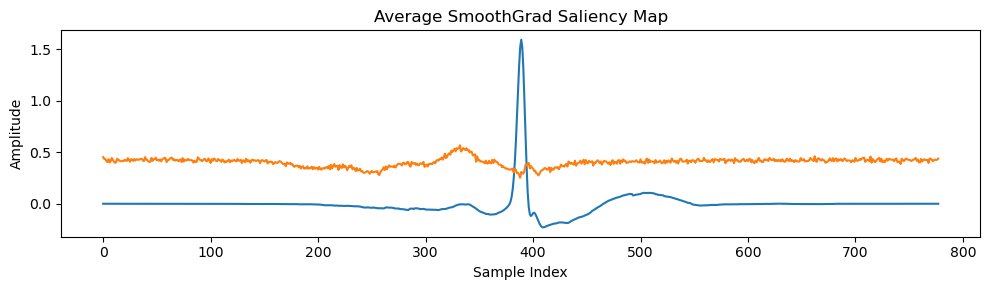

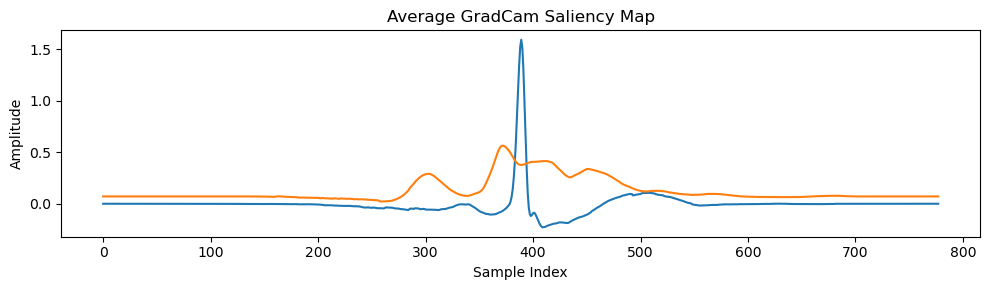

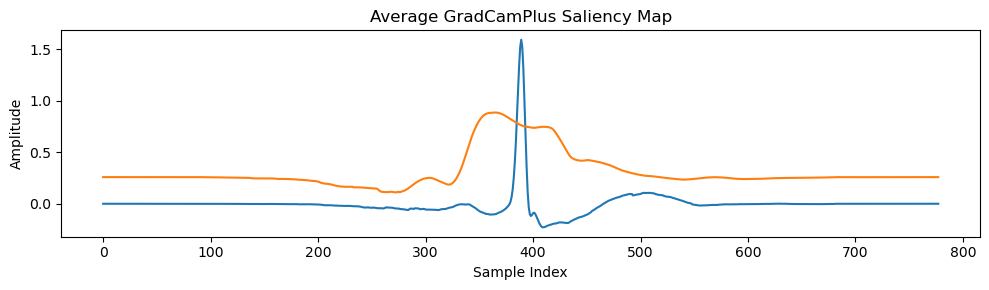

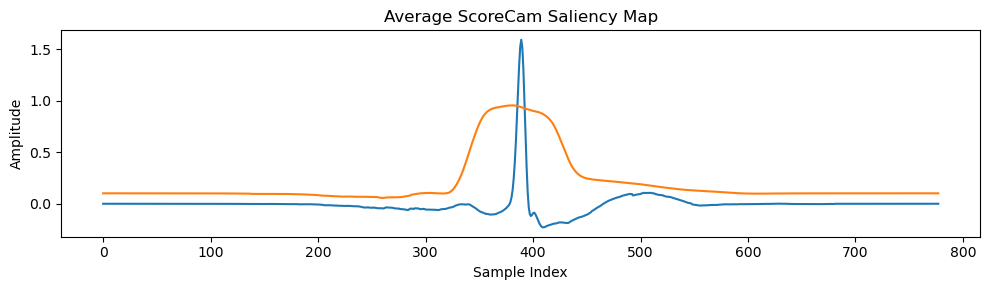

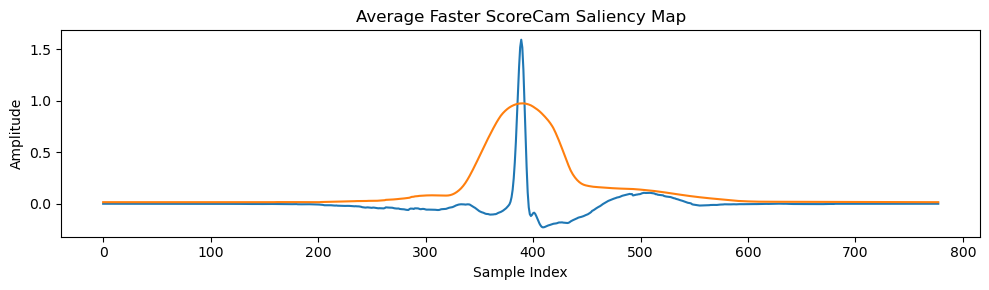

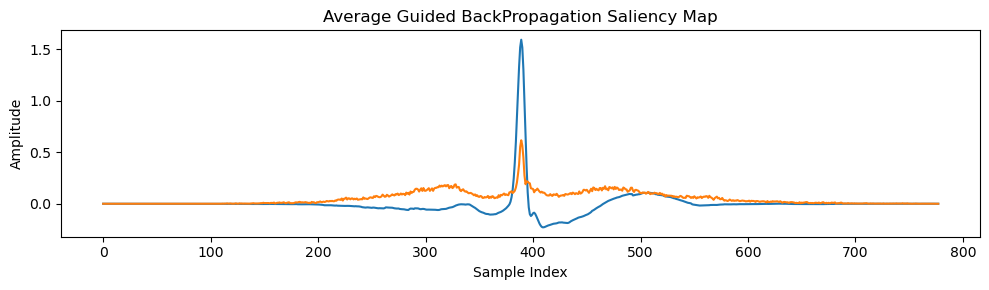

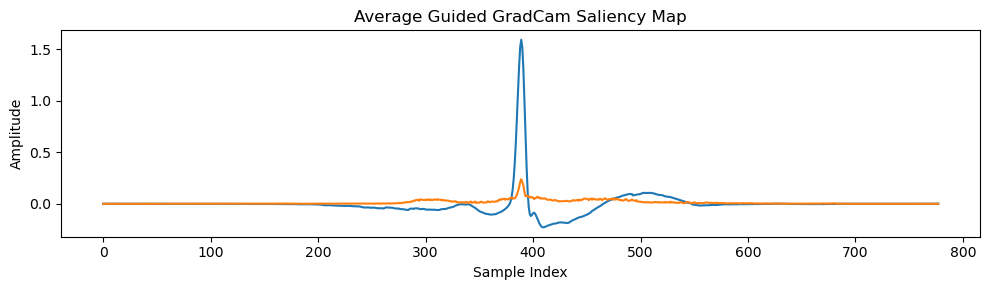

In [32]:
#find the center of the signal, where all R peaks will be aligned
center = signals_top100.shape[1] // 2
# create a new array of shape (100, 778) filled with zeros, to hold the shifted beats.
aligned = np.zeros_like(signals_top100)

# shift each beat so its R-peak lands at center
for n, (sig, r_loc) in enumerate(zip(signals_top100, r_peaks)):
    shift = center - r_loc
    aligned[n] = np.roll(sig, shift)

#compute avg ecg
avg_aligned = np.mean(aligned, axis=0)

for i, sal in enumerate(all_avg_saliency):
    aligned_sal = np.zeros_like(sal)
    
    for n, r_loc in enumerate(r_peaks):
        shift = center - r_loc
        aligned_sal[n] = np.roll(sal[n], shift)
    
    avg_saliency = aligned_sal.mean(axis=0)

    plt.figure(figsize=(10, 3))
    plt.plot(avg_aligned)
    plt.plot(avg_saliency)
    plt.title(f"Average {title_sal[i]} Saliency Map")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

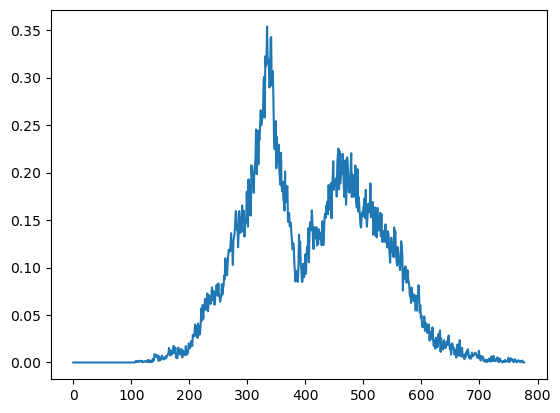

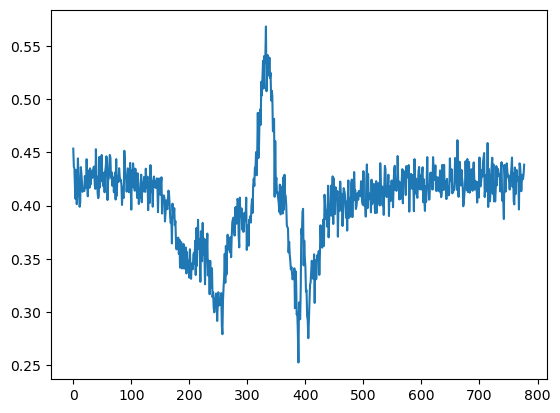

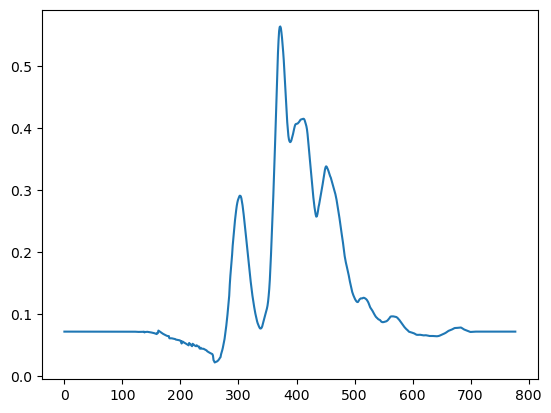

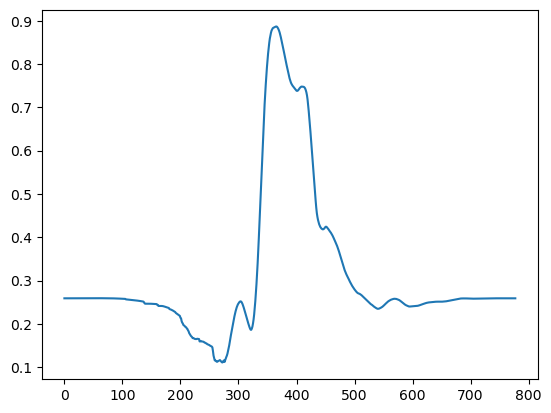

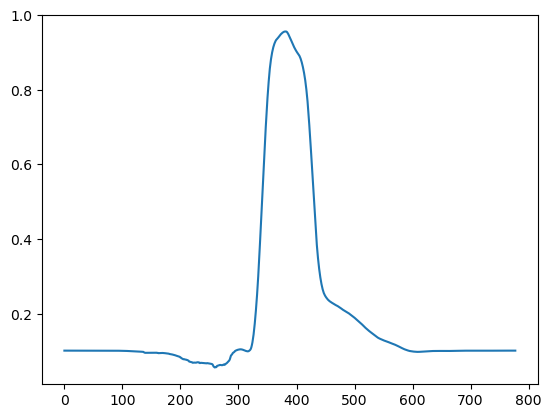

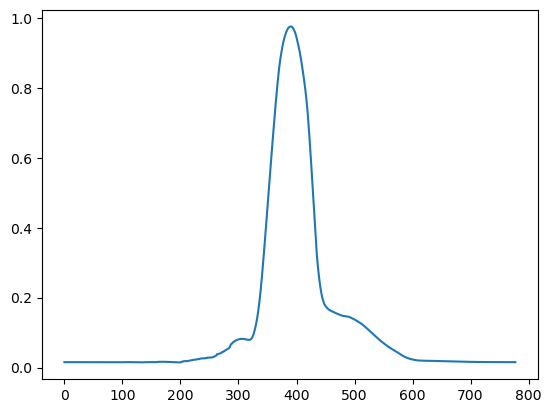

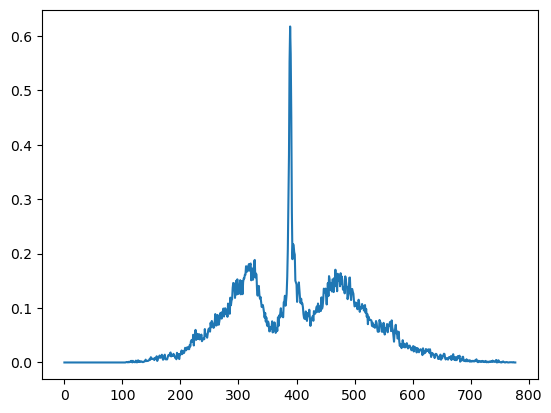

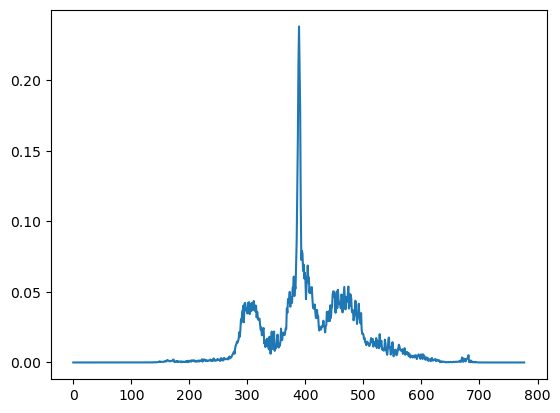

In [33]:

for sal in all_avg_saliency:
    aligned_sal = np.zeros_like(sal)
    
    for n, r_loc in enumerate(r_peaks):
        shift = center - r_loc
        aligned_sal[n] = np.roll(sal[n], shift)
    
    avg_saliency = aligned_sal.mean(axis=0)

    plt.plot(avg_saliency)
    plt.show()

# Activation Maximization

this section visualizes what different filters are highly activated by. Essentially what are the filters looking out for. This is done for the last conv layer and last dense layer as a test for now

## Last Conv Layer

I0000 00:00:1752509217.833701    6694 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - 5s 19ms/step - Score: 3335.6587 - Norm: 504.6592


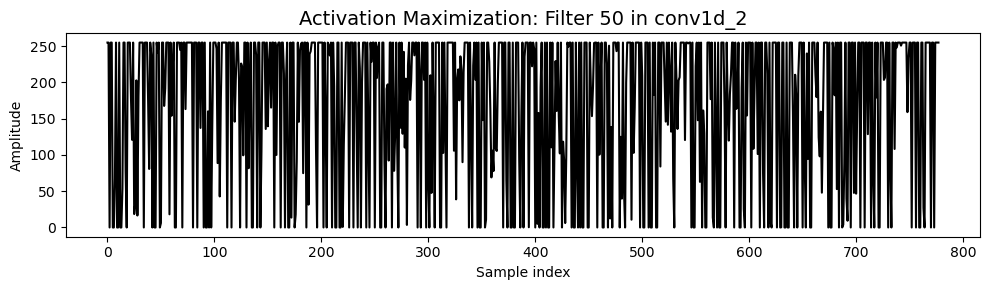

200/200 [==============================] - 4s 18ms/step - Score: 6607.6543 - Norm: 735.1197


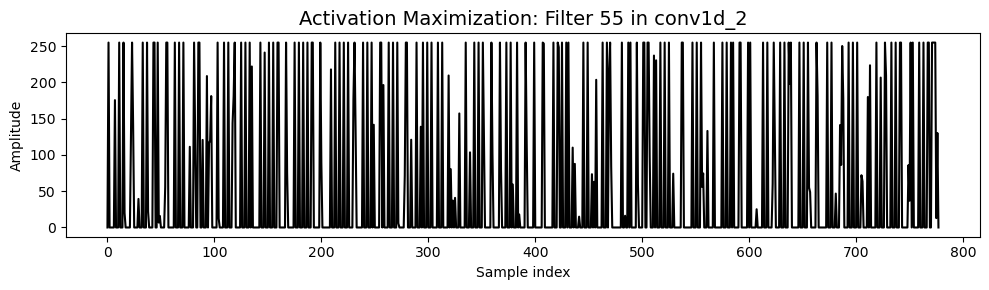

200/200 [==============================] - 4s 18ms/step - Score: 652.0927 - Norm: 242.4460


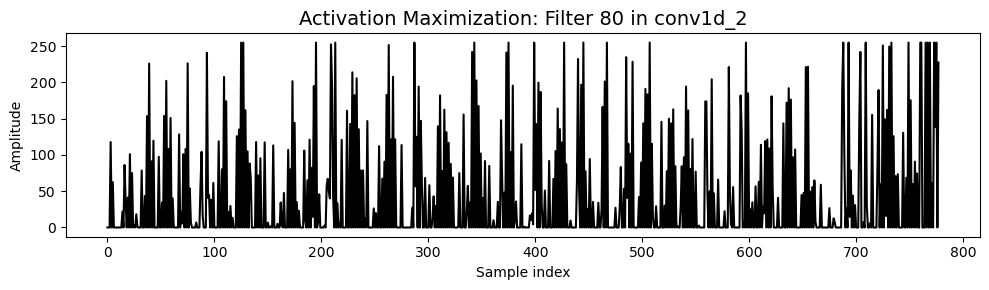

200/200 [==============================] - 4s 17ms/step - Score: 14907.3125 - Norm: 894.3529


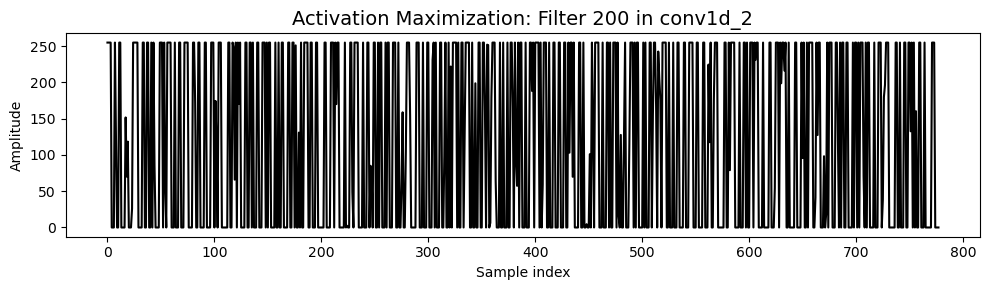

200/200 [==============================] - 4s 18ms/step - Score: -10.9445 - Norm: 30.2133


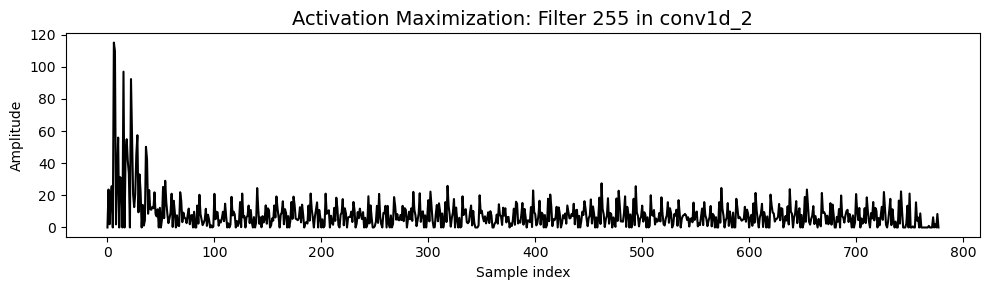

In [34]:
layer_name = 'conv1d_2' #target layer

#new model whose output is replaced to `block5_conv3` layer's output
extract_intermediate_layer = ExtractIntermediateLayer(index_or_name=layer_name)
#modify the model's last activation function to linear
replace2linear = ReplaceToLinear()

activation_maximization = ActivationMaximization(
    model,
    model_modifier=[extract_intermediate_layer, replace2linear],
    clone=False)

seq_len = samples.shape[1]
seed_input = np.random.normal(size=(1, seq_len, 1)).astype(np.float32)

filter_numbers = [50,55,80,200,255]
nrows = 1
ncols = len(filter_numbers)


for idx, i in enumerate(filter_numbers):
    def score_am(output):
        return tf.reduce_mean(output[:, :, i])

    # Generate maximized activation
    activations = activation_maximization(score_am, seed_input=seed_input, input_modifiers=[], regularizers=[Norm(2)], callbacks=[Progress()])
    activations = activations.numpy()

    plt.figure(figsize=(10, 3))
    plt.plot(activations[0].squeeze(), color='black')
    plt.title(f'Activation Maximization: Filter {i} in {layer_name}', fontsize=14)
    plt.xlabel("Sample index")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

## Last Dense Layer

200/200 [==============================] - 5s 27ms/step - Score: 17690.7266 - Norm: 781.9435


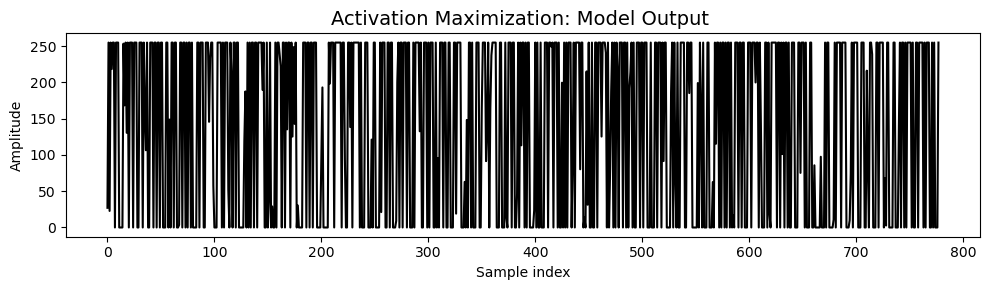

In [35]:
def score_dense(output):
    return output[:, 0]
    
activation_maximization = ActivationMaximization(model, model_modifier = None, clone=True)

seq_len = samples.shape[1]
seed_input = np.random.normal(size=(1, seq_len, 1)).astype(np.float32)

# Generate maximized activation
activations = activation_maximization(score_dense, seed_input=seed_input, input_modifiers=[], regularizers=[Norm(2)], callbacks=[Progress()])
activations = activations.numpy()

plt.figure(figsize=(10, 3))
plt.plot(activations[0].squeeze(), color='black')
plt.title(f'Activation Maximization: Model Output ', fontsize=14)
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()